## Setup & Imports

In [5]:
!pip install ipympl
!pip install optuna

In [6]:
# !pip install nibabel matplotlib

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import torch
from scipy.ndimage import zoom
from tqdm import tqdm
import torch.nn.functional as F
from matplotlib.widgets import Slider
import plotly.graph_objects as go
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.optim import Adam
from concurrent.futures import ThreadPoolExecutor, as_completed

from scipy.ndimage import rotate
import optuna

from optuna.pruners import MedianPruner
from torch.cuda.amp import autocast, GradScaler

## Mount Google Drive

In [7]:
# # Mount Google Drive to access dataset files
# drive.mount('/content/drive')


## Load NIfTI Files

In [8]:
# Define data path and list NIfTI (.nii) files
data_path = "/kaggle/input/aims-tbs-challenge-files/ChallengeFiles"
file_list = sorted([f for f in os.listdir(data_path) if f.endswith('.nii')])

print(f"Found {len(file_list)} nii files")
print(file_list[:5])  # Show first 5 files


Found 1103 nii files
['scan_0001_Lesion.nii', 'scan_0001_T1.nii', 'scan_0004_Lesion.nii', 'scan_0004_T1.nii', 'scan_0007_Lesion.nii']


## Read Sample NIfTI File & Normalize

- .nii file are 3d images
- consider slices as the 2d images stacked together to create a 3d one

In [9]:
# Load a sample NIfTI file
nii_file = os.path.join(data_path, file_list[0])
img = nib.load(nii_file)
img_data = img.get_fdata()

print(f"Loaded file: {file_list[1]}")
print(f"Image shape: {img_data.shape}")

# Intensity normalization function for visualization
def normalize_slice(slice_data):
    slice_min = slice_data.min()
    slice_max = slice_data.max()
    if slice_max - slice_min > 0:
        return (slice_data - slice_min) / (slice_max - slice_min)
    else:
        return slice_data  # In case slice is constant


Loaded file: scan_0001_T1.nii
Image shape: (256, 256, 256)


### VIsualizing Slices

Medical image slices (like MRI or CT scans) are displayed in grayscale, where pixel values are mapped to shades from black (low intensity) to white (high intensity).

*   **Black Areas:** Typically represent regions with very low signal intensity. This includes the background (air), air-filled cavities, and certain tissue types depending on the scan method (e.g., bone or CSF in some MRI sequences, air in CT).
*   **White/Brighter Areas:** Represent regions with high signal intensity. This includes dense tissues (like bone in CT), certain tissue properties in MRI (like fat in T1-weighted or fluid/edema in T2-weighted), or areas with contrast agent uptake.

The contrast between dark and bright areas helps visualize

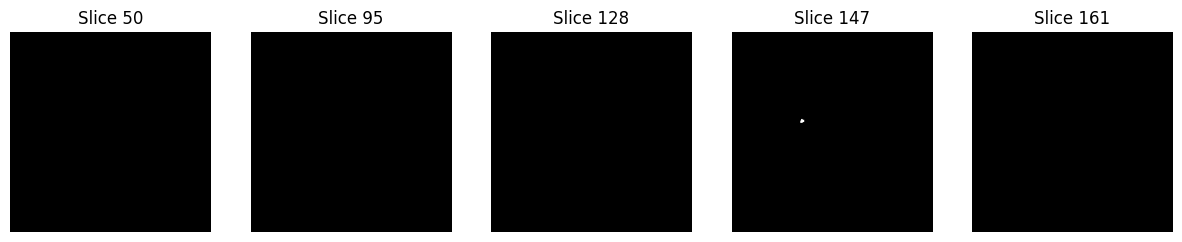

In [10]:
num_slices = 5
fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

# Random unique slice indices from the axial dimension (depth)
slice_indices = np.random.choice(img_data.shape[2], size=num_slices, replace=False)
slice_indices = np.sort(slice_indices)  # optional: sort for nicer display order

for i, slice_idx in enumerate(slice_indices):
    slice_img = img_data[:, :, slice_idx].T
    norm_img = normalize_slice(slice_img)
    axes[i].imshow(norm_img, cmap='gray', origin='lower')
    axes[i].set_title(f"Slice {slice_idx}")
    axes[i].axis('off')

plt.show()

### Visualizing T1 Image with Lesion Mask

This code block loads both a T1-weighted MRI image and its corresponding lesion segmentation mask for the same scan. It then displays a series of slices from a specified range, overlaying the lesion mask on top of the T1 image to highlight the location and extent of the lesion.

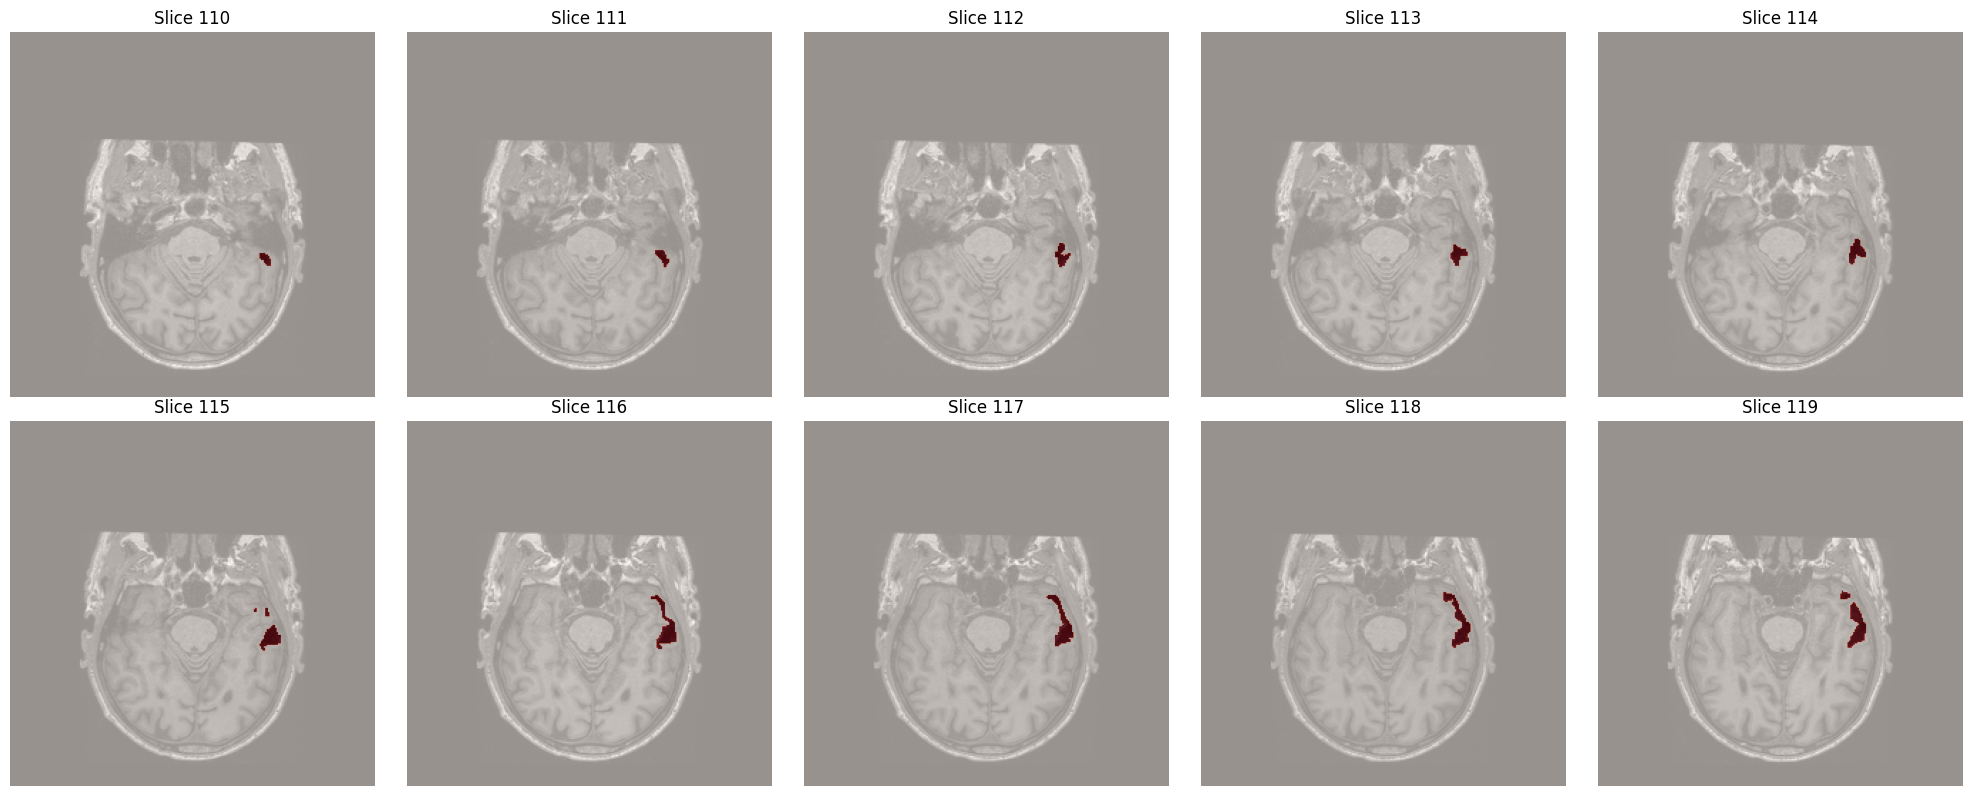

In [11]:
# Load both the T1 image and the Lesion mask
t1_file = os.path.join(data_path, 'scan_0001_T1.nii')
lesion_file = os.path.join(data_path, 'scan_0001_Lesion.nii')

t1_img = nib.load(t1_file).get_fdata()
lesion_img = nib.load(lesion_file).get_fdata()

# User-defined slice range
start_slice = 110
num_slices = 10

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(num_slices):
    slice_idx = start_slice + i
    t1_slice = t1_img[:, :, slice_idx].T
    lesion_slice = lesion_img[:, :, slice_idx].T

    axes[i].imshow(t1_slice, cmap='gray', origin='lower')
    axes[i].imshow(lesion_slice, cmap='Reds', alpha=0.6, origin='lower')
    axes[i].set_title(f"Slice {slice_idx}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Visualizing Coronal and Sagittal Slices

This code block demonstrates how to extract and visualize slices from the 3D image data (`img_data`) along planes other than the standard axial view. Specifically, it shows how to display a coronal slice and a sagittal slice from the middle of the image volume.

*   Medical 3D images can be viewed as stacks of 2D slices along different orientations:
    *   **Axial (or Transverse) slices:** Imagine slicing the body horizontally, like slicing a loaf of bread. These separate the top from the bottom.
    *   **Coronal slices:** Imagine slicing the body vertically from side-to-side, separating the front (anterior) from the back (posterior). This code visualizes a coronal slice.
    *   **Sagittal slices:** Imagine slicing the body vertically from front to back, separating the left side from the right side. This code visualizes a sagittal slice.

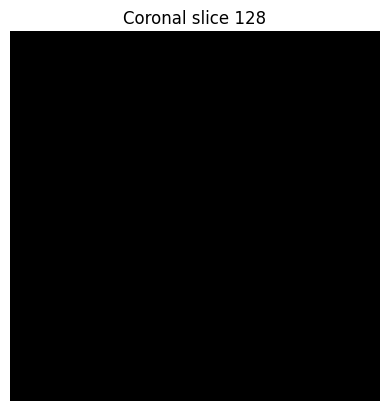

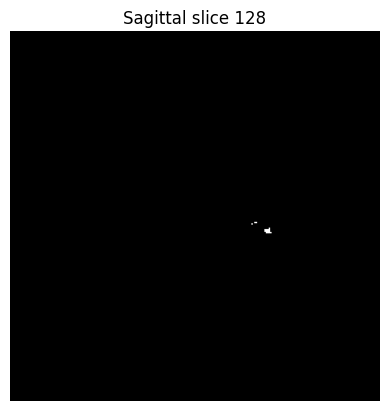

In [12]:
# Coronal slice (YZ plane)
slice_idx = img_data.shape[0] // 2
coronal_slice = normalize_slice(img_data[slice_idx, :, :].T)
plt.imshow(coronal_slice, cmap='gray', origin='lower')
plt.title(f"Coronal slice {slice_idx}")
plt.axis('off')
plt.show()

# Sagittal slice (XZ plane)
slice_idx = img_data.shape[1] // 2
sagittal_slice = normalize_slice(img_data[:, slice_idx, :].T)
plt.imshow(sagittal_slice, cmap='gray', origin='lower')
plt.title(f"Sagittal slice {slice_idx}")
plt.axis('off')
plt.show()


### Image Intensity Distribution and Non-Zero Voxels

- This code block analyzes the distribution of intensity values within the entire 3D image and calculates the proportion of voxels (3D pixels) that have non-zero intensity values.
- This helps understand the overall characteristics of the image data, such as the range of intensities present and how much of the image volume is not just background.

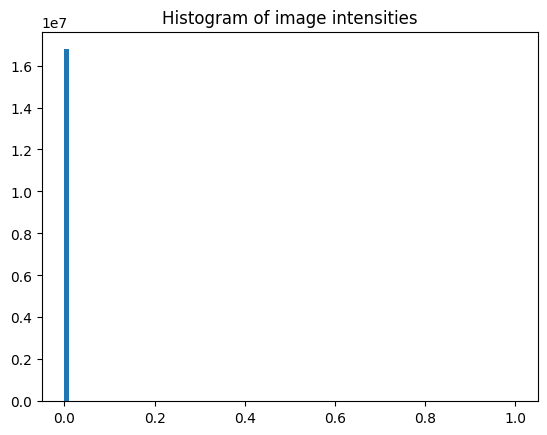

Non-zero voxels: 2150 / 16777216 (0.01%)


In [13]:
plt.hist(img_data.flatten(), bins=100)
plt.title("Histogram of image intensities")
plt.show()

nonzero_voxels = np.count_nonzero(img_data)
total_voxels = img_data.size
print(f"Non-zero voxels: {nonzero_voxels} / {total_voxels} ({100*nonzero_voxels/total_voxels:.2f}%)")


## Preprocessing pipeline

### Preprocessing Function

In [14]:
# def preprocess_scan(scan_path, mask_path=None, target_shape=(128, 128, 128), device='cuda'):
#     """
#     Preprocess T1 scan and mask using PyTorch (GPU-accelerated).

#     Loads and preprocesses a T1 MRI scan and optionally a lesion mask.

#     Args:
#         scan_path (str): Path to the T1-weighted MRI scan (.nii)
#         mask_path (str or None): Path to the lesion mask (.nii), if available
#         target_shape (tuple): Desired output shape for the scan/mask (D, H, W)
#         device (str): Device to perform computations on (e.g., 'cuda' or 'cpu')

#     Returns:
#         scan_tensor (torch.Tensor): Normalized and resampled scan tensor [1, D, H, W]
#         mask_tensor (torch.Tensor or None): Binarized and resampled mask tensor [1, D, H, W]
#         stats (dict): Dictionary with scan mean, std, and number of lesion voxels
#     """
#     # === Load scan as NumPy array using nibabel (CPU) ===
#     scan_np = nib.load(scan_path).get_fdata().astype(np.float32)  # Shape: [D, H, W]

#     # === Normalize scan to range [0, 1] ===
#     scan_np = (scan_np - scan_np.min()) / (scan_np.max() - scan_np.min() + 1e-5)

#     # === Convert scan to PyTorch tensor and move to GPU ===
#     # Add batch and channel dimensions: [1, 1, D, H, W]
#     scan_tensor = torch.tensor(scan_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

#     # === Resample (resize) scan tensor to target shape using trilinear interpolation ===
#     scan_tensor = F.interpolate(scan_tensor, size=target_shape, mode='trilinear', align_corners=False)

#     # Remove batch dimension: resulting shape [1, D, H, W]
#     scan_tensor = scan_tensor.squeeze(0)

#     # === Compute scan statistics ===
#     scan_mean = float(scan_tensor.mean())  # Global mean
#     scan_std = float(scan_tensor.std())    # Global standard deviation

#     # === Initialize outputs for lesion mask ===
#     mask_tensor = None
#     lesion_voxels = -1  # Default to -1 if no mask is provided

#     # === If mask path is provided, process the lesion mask ===
#     if mask_path:
#         # Load mask as NumPy array and binarize: values will be 0 or 1
#         mask_np = nib.load(mask_path).get_fdata().astype(np.uint8)
#         mask_np = (mask_np > 0).astype(np.float32)

#         # Convert to tensor, add batch/channel dims, and move to GPU
#         mask_tensor = torch.tensor(mask_np).unsqueeze(0).unsqueeze(0).to(device)

#         # Resample mask to target shape using nearest neighbor interpolation (preserves binary values)
#         mask_tensor = F.interpolate(mask_tensor, size=target_shape, mode='nearest')

#         # Remove batch dimension: resulting shape [1, D, H, W]
#         mask_tensor = mask_tensor.squeeze(0)

#         # Count number of lesion voxels (sum of binary mask)
#         lesion_voxels = int(mask_tensor.sum().item())

#     # === Collect scan statistics ===
#     stats = {
#         'scan_mean': scan_mean,
#         'scan_std': scan_std,
#         'lesion_voxels': lesion_voxels
#     }

#     return scan_tensor, mask_tensor, stats


In [15]:
def advanced_preprocess_scan(scan_path, mask_path=None, target_shape=(128, 128, 128), device='cuda'):
    """
    Advanced preprocessing with intensity normalization and augmentation-ready format.
    """
    # Load scan
    scan_np = nib.load(scan_path).get_fdata().astype(np.float32)
    
    # Advanced intensity normalization (Z-score normalization)
    # Clip extreme outliers first
    p1, p99 = np.percentile(scan_np[scan_np > 0], [1, 99])
    scan_np = np.clip(scan_np, p1, p99)
    
    # Z-score normalization on non-zero voxels
    non_zero_mask = scan_np > 0
    if non_zero_mask.sum() > 0:
        mean_val = scan_np[non_zero_mask].mean()
        std_val = scan_np[non_zero_mask].std()
        scan_np[non_zero_mask] = (scan_np[non_zero_mask] - mean_val) / (std_val + 1e-8)
    
    # Convert to tensor and resize
    scan_tensor = torch.tensor(scan_np).unsqueeze(0).unsqueeze(0).to(device)
    scan_tensor = F.interpolate(scan_tensor, size=target_shape, mode='trilinear', align_corners=False)
    scan_tensor = scan_tensor.squeeze(0)
    
    # Process mask if provided
    mask_tensor = None
    if mask_path and os.path.exists(mask_path):
        mask_np = nib.load(mask_path).get_fdata().astype(np.float32)
        mask_np = (mask_np > 0).astype(np.float32)
        print(f"Mask {mask_path} sum: {mask_np.sum()}")
        mask_tensor = torch.tensor(mask_np).unsqueeze(0).unsqueeze(0).to(device)
        mask_tensor = F.interpolate(mask_tensor, size=target_shape, mode='nearest')
        mask_tensor = mask_tensor.squeeze(0)
    
    return scan_tensor, mask_tensor

Data Augmentation

In [16]:
class TBIAugmentation:
    def __init__(self, p=0.5):
        self.p = p
    
    def __len__(self):  # ADD THIS METHOD
        return len(self.ids)
    
    def __call__(self, scan, lesion):
        if torch.rand(1) < self.p:
            # Random rotation (small angles)
            angle = torch.randint(-15, 15, (1,)).item()
            scan = self.rotate_3d(scan, angle)
            lesion = self.rotate_3d(lesion, angle)
        
        if torch.rand(1) < self.p:
            # Random flip
            axis = torch.randint(2, 5, (1,)).item()  # axes 2,3,4 (spatial)
            scan = torch.flip(scan, [axis])
            lesion = torch.flip(lesion, [axis])
        
        if torch.rand(1) < self.p:
            # Gaussian noise
            noise = torch.randn_like(scan) * 0.1
            scan = scan + noise
        
        if torch.rand(1) < self.p:
            # Intensity scaling
            scale = torch.uniform(0.8, 1.2, (1,)).item()
            scan = scan * scale
        
        return scan, lesion
    
    def rotate_3d(self, tensor, angle):
        # Simple rotation around one axis
        return tensor  # Implement based on your needs

# Update dataset class
class TBI3DSegmentationDataset(Dataset):
    def __init__(self, data_dict, transform=None, augment=False):
        self.ids = list(data_dict.keys())
        self.data = data_dict
        self.transform = transform
        self.augment = TBIAugmentation() if augment else None

    def __getitem__(self, idx):
        scan_id = self.ids[idx]
        scan = self.data[scan_id]["scan"]
        lesion = self.data[scan_id]["lesion"]

        scan = scan.squeeze().unsqueeze(0)
        lesion = lesion.squeeze().unsqueeze(0)

        if self.augment:
            scan, lesion = self.augment(scan, lesion)

        return scan, lesion

### Process All Files & Detect Noisy Scans

In [17]:
raw_path = "/kaggle/input/aims-tbs-challenge-files/ChallengeFiles"
save_path = "./PreprocessedData"
os.makedirs(save_path, exist_ok=True)

In [18]:
target_shape = (128, 128, 128)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# === Step 1: Get all scan IDs ===
all_files = os.listdir(raw_path)
scan_ids = sorted(list(set('_'.join(f.split('_')[:-1]) for f in all_files if f.endswith("_T1.nii"))))

# === Step 2: Start preprocessing ===
processed = 0
skipped = 0
results = []

for scan_id in tqdm(scan_ids):
    t1_path = os.path.join(raw_path, f"{scan_id}_T1.nii")
    lesion_path = os.path.join(raw_path, f"{scan_id}_Lesion.nii")

    t1_out = os.path.join(save_path, f"{scan_id}_T1.pt")
    lesion_out = os.path.join(save_path, f"{scan_id}_Lesion.pt")

    if os.path.exists(t1_out) and os.path.exists(lesion_out):
        skipped += 1
        continue

    try:
        # === Use advanced preprocessing ===
        scan_tensor, mask_tensor = advanced_preprocess_scan(t1_path, lesion_path, target_shape=target_shape, device=device)

        # Save processed tensors
        torch.save(scan_tensor.cpu(), t1_out)
        if mask_tensor is not None:
            torch.save(mask_tensor.cpu(), lesion_out)

        processed += 1

        # (Optional) store stats for logging/debugging
        stats = {
            "scan_id": scan_id,
            "mean": scan_tensor.mean().item(),
            "std": scan_tensor.std().item(),
            "lesion_voxels": mask_tensor.sum().item() if mask_tensor is not None else 0,
        }
        results.append(stats)

    except Exception as e:
        print(f"❌ Error processing {scan_id}: {e}")

print(f"\n✅ Finished preprocessing: {processed} scans processed, {skipped} skipped.")

  0%|          | 1/551 [00:01<17:21,  1.89s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0001_Lesion.nii sum: 2150.0


  0%|          | 2/551 [00:04<21:55,  2.40s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0004_Lesion.nii sum: 833.0


  1%|          | 3/551 [00:07<22:33,  2.47s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0007_Lesion.nii sum: 3253.0


  1%|          | 4/551 [00:09<23:37,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0016_Lesion.nii sum: 0.0


  1%|          | 5/551 [00:12<24:50,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0017_Lesion.nii sum: 214.0


  1%|          | 6/551 [00:15<24:18,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0019_Lesion.nii sum: 1970.0


  1%|▏         | 7/551 [00:18<24:21,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0020_Lesion.nii sum: 495.0


  1%|▏         | 8/551 [00:20<23:59,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0021_Lesion.nii sum: 135.0


  2%|▏         | 9/551 [00:23<24:22,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0024_Lesion.nii sum: 2752.0


  2%|▏         | 10/551 [00:26<24:01,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0028_Lesion.nii sum: 21454.0


  2%|▏         | 11/551 [00:28<24:17,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0029_Lesion.nii sum: 2898.0


  2%|▏         | 12/551 [00:31<23:40,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0033_Lesion.nii sum: 0.0


  2%|▏         | 13/551 [00:34<24:14,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0036_Lesion.nii sum: 4226.0


  3%|▎         | 14/551 [00:36<23:21,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0038_Lesion.nii sum: 4514.0


  3%|▎         | 15/551 [00:39<23:40,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0040_Lesion.nii sum: 0.0


  3%|▎         | 16/551 [00:42<23:56,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0041_Lesion.nii sum: 121372.0


  3%|▎         | 17/551 [00:44<24:01,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0042_Lesion.nii sum: 417.0


  3%|▎         | 18/551 [00:47<23:58,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0044_Lesion.nii sum: 867.0


  3%|▎         | 19/551 [00:50<23:05,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0045_Lesion.nii sum: 20.0


  4%|▎         | 20/551 [00:52<23:34,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0049_Lesion.nii sum: 41887.0


  4%|▍         | 21/551 [00:55<23:43,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0050_Lesion.nii sum: 0.0


  4%|▍         | 22/551 [00:58<24:31,  2.78s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0052_Lesion.nii sum: 195.0


  4%|▍         | 23/551 [00:59<18:50,  2.14s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0053_Lesion.nii sum: 10953.0


  4%|▍         | 24/551 [01:02<20:35,  2.34s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0056_Lesion.nii sum: 62135.0


  5%|▍         | 25/551 [01:04<21:43,  2.48s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0057_Lesion.nii sum: 41091.0


  5%|▍         | 26/551 [01:07<22:44,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0058_Lesion.nii sum: 4300.0


  5%|▍         | 27/551 [01:10<23:18,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0059_Lesion.nii sum: 0.0


  5%|▌         | 28/551 [01:13<23:19,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0061_Lesion.nii sum: 488.0


  5%|▌         | 29/551 [01:15<23:06,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0062_Lesion.nii sum: 325.0


  5%|▌         | 30/551 [01:18<22:59,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0063_Lesion.nii sum: 792.0


  6%|▌         | 31/551 [01:20<22:33,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0070_Lesion.nii sum: 348.0


  6%|▌         | 32/551 [01:23<22:14,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0073_Lesion.nii sum: 176.0


  6%|▌         | 33/551 [01:25<21:39,  2.51s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0077_Lesion.nii sum: 0.0


  6%|▌         | 34/551 [01:28<21:34,  2.50s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0080_Lesion.nii sum: 35778.0


  6%|▋         | 35/551 [01:31<22:08,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0086_Lesion.nii sum: 25179.0


  7%|▋         | 36/551 [01:33<22:13,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0089_Lesion.nii sum: 0.0


  7%|▋         | 37/551 [01:36<21:54,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0091_Lesion.nii sum: 135.0


  7%|▋         | 38/551 [01:38<22:05,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0093_Lesion.nii sum: 92.0


  7%|▋         | 39/551 [01:41<22:16,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0096_Lesion.nii sum: 0.0


  7%|▋         | 40/551 [01:44<22:23,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0097_Lesion.nii sum: 173.0


  7%|▋         | 41/551 [01:46<22:32,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0099_Lesion.nii sum: 0.0


  8%|▊         | 42/551 [01:49<22:53,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0101_Lesion.nii sum: 1699.0


  8%|▊         | 43/551 [01:52<22:20,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0104_Lesion.nii sum: 5607.0


  8%|▊         | 44/551 [01:54<22:25,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0105_Lesion.nii sum: 0.0


  8%|▊         | 45/551 [01:57<21:42,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0106_Lesion.nii sum: 0.0


  8%|▊         | 46/551 [01:59<21:47,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0107_Lesion.nii sum: 46103.0


  9%|▊         | 47/551 [02:02<21:17,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0108_Lesion.nii sum: 4530.0


  9%|▊         | 48/551 [02:04<21:33,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0109_Lesion.nii sum: 20.0


  9%|▉         | 49/551 [02:07<21:41,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0110_Lesion.nii sum: 0.0


  9%|▉         | 50/551 [02:10<22:23,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0114_Lesion.nii sum: 743.0


  9%|▉         | 51/551 [02:13<22:32,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0115_Lesion.nii sum: 1094.0


  9%|▉         | 52/551 [02:15<22:18,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0116_Lesion.nii sum: 5792.0


 10%|▉         | 53/551 [02:18<22:41,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0118_Lesion.nii sum: 0.0


 10%|▉         | 54/551 [02:21<22:24,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0120_Lesion.nii sum: 0.0


 10%|▉         | 55/551 [02:24<22:16,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0122_Lesion.nii sum: 0.0


 10%|█         | 56/551 [02:26<21:33,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0125_Lesion.nii sum: 3654.0


 10%|█         | 57/551 [02:28<20:58,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0129_Lesion.nii sum: 91.0


 11%|█         | 58/551 [02:31<21:05,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0130_Lesion.nii sum: 826.0


 11%|█         | 59/551 [02:34<21:03,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0131_Lesion.nii sum: 0.0


 11%|█         | 60/551 [02:36<21:06,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0134_Lesion.nii sum: 2823.0


 11%|█         | 61/551 [02:39<21:07,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0139_Lesion.nii sum: 0.0


 11%|█▏        | 62/551 [02:41<20:37,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0140_Lesion.nii sum: 0.0


 11%|█▏        | 63/551 [02:44<20:12,  2.48s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0141_Lesion.nii sum: 0.0


 12%|█▏        | 64/551 [02:46<20:04,  2.47s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0142_Lesion.nii sum: 0.0


 12%|█▏        | 65/551 [02:49<20:46,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0144_Lesion.nii sum: 3102.0


 12%|█▏        | 66/551 [02:51<20:45,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0145_Lesion.nii sum: 8447.0


 12%|█▏        | 67/551 [02:54<21:04,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0146_Lesion.nii sum: 2544.0


 12%|█▏        | 68/551 [02:56<18:44,  2.33s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0147_Lesion.nii sum: 0.0


 13%|█▎        | 69/551 [02:58<19:35,  2.44s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0148_Lesion.nii sum: 0.0


 13%|█▎        | 70/551 [03:01<19:52,  2.48s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0149_Lesion.nii sum: 0.0


 13%|█▎        | 71/551 [03:04<20:09,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0150_Lesion.nii sum: 4394.0


 13%|█▎        | 72/551 [03:06<20:12,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0152_Lesion.nii sum: 39958.0


 13%|█▎        | 73/551 [03:09<20:45,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0153_Lesion.nii sum: 0.0


 13%|█▎        | 74/551 [03:12<20:39,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0156_Lesion.nii sum: 999.0


 14%|█▎        | 75/551 [03:14<20:26,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0157_Lesion.nii sum: 1906.0


 14%|█▍        | 76/551 [03:16<19:11,  2.42s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0158_Lesion.nii sum: 0.0


 14%|█▍        | 77/551 [03:19<19:22,  2.45s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0159_Lesion.nii sum: 28906.0


 14%|█▍        | 78/551 [03:21<20:09,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0160_Lesion.nii sum: 15452.0


 14%|█▍        | 79/551 [03:24<20:55,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0163_Lesion.nii sum: 9781.0


 15%|█▍        | 80/551 [03:27<20:47,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0164_Lesion.nii sum: 0.0


 15%|█▍        | 81/551 [03:29<20:24,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0167_Lesion.nii sum: 7861.0


 15%|█▍        | 82/551 [03:32<19:57,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0169_Lesion.nii sum: 2022.0


 15%|█▌        | 83/551 [03:34<19:27,  2.49s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0171_Lesion.nii sum: 0.0


 15%|█▌        | 84/551 [03:37<19:30,  2.51s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0173_Lesion.nii sum: 13083.0


 15%|█▌        | 85/551 [03:40<20:24,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0178_Lesion.nii sum: 3726.0


 16%|█▌        | 86/551 [03:42<20:32,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0179_Lesion.nii sum: 31.0


 16%|█▌        | 87/551 [03:45<20:52,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0180_Lesion.nii sum: 61.0


 16%|█▌        | 88/551 [03:48<21:01,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0181_Lesion.nii sum: 0.0


 16%|█▌        | 89/551 [03:51<20:45,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0182_Lesion.nii sum: 581.0


 16%|█▋        | 90/551 [03:53<21:04,  2.74s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0185_Lesion.nii sum: 7212.0


 17%|█▋        | 91/551 [03:56<21:08,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0189_Lesion.nii sum: 0.0


 17%|█▋        | 92/551 [03:59<21:45,  2.84s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0193_Lesion.nii sum: 0.0


 17%|█▋        | 93/551 [04:02<21:53,  2.87s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0194_Lesion.nii sum: 4256.0


 17%|█▋        | 94/551 [04:05<21:25,  2.81s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0197_Lesion.nii sum: 25.0


 17%|█▋        | 95/551 [04:08<21:12,  2.79s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0199_Lesion.nii sum: 16653.0


 17%|█▋        | 96/551 [04:10<20:48,  2.74s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0203_Lesion.nii sum: 0.0


 18%|█▊        | 97/551 [04:13<20:02,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0204_Lesion.nii sum: 1128.0


 18%|█▊        | 98/551 [04:15<19:53,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0205_Lesion.nii sum: 61296.0


 18%|█▊        | 99/551 [04:18<19:36,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0206_Lesion.nii sum: 0.0


 18%|█▊        | 100/551 [04:20<19:31,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0207_Lesion.nii sum: 0.0


 18%|█▊        | 101/551 [04:23<20:00,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0209_Lesion.nii sum: 177.0


 19%|█▊        | 102/551 [04:26<19:52,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0210_Lesion.nii sum: 179.0


 19%|█▊        | 103/551 [04:28<19:44,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0211_Lesion.nii sum: 50095.0


 19%|█▉        | 104/551 [04:31<19:39,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0212_Lesion.nii sum: 605.0


 19%|█▉        | 105/551 [04:34<19:14,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0213_Lesion.nii sum: 3910.0


 19%|█▉        | 106/551 [04:36<19:48,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0214_Lesion.nii sum: 15324.0


 19%|█▉        | 107/551 [04:39<19:35,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0217_Lesion.nii sum: 47914.0


 20%|█▉        | 108/551 [04:41<18:52,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0219_Lesion.nii sum: 0.0


 20%|█▉        | 109/551 [04:44<18:35,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0220_Lesion.nii sum: 453.0


 20%|█▉        | 110/551 [04:47<19:19,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0222_Lesion.nii sum: 2039.0


 20%|██        | 111/551 [04:49<19:34,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0224_Lesion.nii sum: 775.0


 20%|██        | 112/551 [04:52<19:27,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0225_Lesion.nii sum: 0.0


 21%|██        | 113/551 [04:55<18:50,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0227_Lesion.nii sum: 0.0


 21%|██        | 114/551 [04:57<19:15,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0228_Lesion.nii sum: 0.0


 21%|██        | 115/551 [05:00<18:27,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0229_Lesion.nii sum: 3709.0


 21%|██        | 116/551 [05:02<18:43,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0234_Lesion.nii sum: 214208.0


 21%|██        | 117/551 [05:05<18:38,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0236_Lesion.nii sum: 0.0


 21%|██▏       | 118/551 [05:07<18:11,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0237_Lesion.nii sum: 0.0


 22%|██▏       | 119/551 [05:09<17:07,  2.38s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0243_Lesion.nii sum: 0.0


 22%|██▏       | 120/551 [05:12<17:44,  2.47s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0245_Lesion.nii sum: 28.0


 22%|██▏       | 121/551 [05:15<18:10,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0246_Lesion.nii sum: 0.0


 22%|██▏       | 122/551 [05:17<18:19,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0247_Lesion.nii sum: 3481.0


 22%|██▏       | 123/551 [05:20<18:28,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0248_Lesion.nii sum: 57846.0


 23%|██▎       | 124/551 [05:22<17:47,  2.50s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0249_Lesion.nii sum: 2359.0


 23%|██▎       | 125/551 [05:25<18:02,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0254_Lesion.nii sum: 0.0


 23%|██▎       | 126/551 [05:27<18:09,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0256_Lesion.nii sum: 578.0


 23%|██▎       | 127/551 [05:30<18:11,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0258_Lesion.nii sum: 0.0


 23%|██▎       | 128/551 [05:33<17:54,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0261_Lesion.nii sum: 5381.0


 23%|██▎       | 129/551 [05:35<17:53,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0270_Lesion.nii sum: 4300.0


 24%|██▎       | 130/551 [05:38<18:06,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0271_Lesion.nii sum: 0.0


 24%|██▍       | 131/551 [05:40<17:45,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0273_Lesion.nii sum: 262.0


 24%|██▍       | 132/551 [05:43<17:56,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0275_Lesion.nii sum: 0.0


 24%|██▍       | 133/551 [05:45<17:51,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0277_Lesion.nii sum: 4113.0


 24%|██▍       | 134/551 [05:48<18:03,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0279_Lesion.nii sum: 1231.0


 25%|██▍       | 135/551 [05:50<17:28,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0281_Lesion.nii sum: 0.0


 25%|██▍       | 136/551 [05:53<17:00,  2.46s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0283_Lesion.nii sum: 0.0


 25%|██▍       | 137/551 [05:55<17:34,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0284_Lesion.nii sum: 76278.0


 25%|██▌       | 138/551 [05:58<17:50,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0290_Lesion.nii sum: 1266.0


 25%|██▌       | 139/551 [06:01<17:59,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0294_Lesion.nii sum: 246.0


 25%|██▌       | 140/551 [06:03<17:48,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0296_Lesion.nii sum: 0.0


 26%|██▌       | 141/551 [06:06<17:53,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0297_Lesion.nii sum: 243.0


 26%|██▌       | 142/551 [06:09<17:58,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0298_Lesion.nii sum: 0.0


 26%|██▌       | 143/551 [06:11<17:47,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0299_Lesion.nii sum: 31351.0


 26%|██▌       | 144/551 [06:14<17:49,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0301_Lesion.nii sum: 3795.0


 26%|██▋       | 145/551 [06:17<18:32,  2.74s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0302_Lesion.nii sum: 1395.0


 26%|██▋       | 146/551 [06:20<18:39,  2.77s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0308_Lesion.nii sum: 3110.0


 27%|██▋       | 147/551 [06:23<18:42,  2.78s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0310_Lesion.nii sum: 2034.0


 27%|██▋       | 148/551 [06:25<18:23,  2.74s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0311_Lesion.nii sum: 36202.0


 27%|██▋       | 149/551 [06:28<18:30,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0315_Lesion.nii sum: 6714.0


 27%|██▋       | 150/551 [06:31<17:53,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0316_Lesion.nii sum: 1091.0


 27%|██▋       | 151/551 [06:33<17:19,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0320_Lesion.nii sum: 0.0


 28%|██▊       | 152/551 [06:36<17:28,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0323_Lesion.nii sum: 11214.0


 28%|██▊       | 153/551 [06:38<17:27,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0324_Lesion.nii sum: 35.0


 28%|██▊       | 154/551 [06:40<16:10,  2.45s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0328_Lesion.nii sum: 0.0


 28%|██▊       | 155/551 [06:43<16:25,  2.49s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0329_Lesion.nii sum: 0.0


 28%|██▊       | 156/551 [06:45<16:16,  2.47s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0331_Lesion.nii sum: 412.0


 28%|██▊       | 157/551 [06:48<16:57,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0333_Lesion.nii sum: 0.0


 29%|██▊       | 158/551 [06:51<17:23,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0340_Lesion.nii sum: 124.0


 29%|██▉       | 159/551 [06:53<16:50,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0341_Lesion.nii sum: 0.0


 29%|██▉       | 160/551 [06:56<16:29,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0344_Lesion.nii sum: 0.0


 29%|██▉       | 161/551 [06:59<16:59,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0346_Lesion.nii sum: 22432.0


 29%|██▉       | 162/551 [07:01<17:24,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0351_Lesion.nii sum: 868.0


 30%|██▉       | 163/551 [07:04<17:05,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0354_Lesion.nii sum: 6265.0


 30%|██▉       | 164/551 [07:06<16:33,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0359_Lesion.nii sum: 238.0


 30%|██▉       | 165/551 [07:09<16:11,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0360_Lesion.nii sum: 0.0


 30%|███       | 166/551 [07:11<16:25,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0361_Lesion.nii sum: 0.0


 30%|███       | 167/551 [07:14<16:28,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0362_Lesion.nii sum: 6721.0


 30%|███       | 168/551 [07:17<16:15,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0365_Lesion.nii sum: 0.0


 31%|███       | 169/551 [07:19<16:43,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0367_Lesion.nii sum: 1270.0


 31%|███       | 170/551 [07:22<16:12,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0368_Lesion.nii sum: 0.0


 31%|███       | 171/551 [07:24<16:00,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0371_Lesion.nii sum: 2299.0


 31%|███       | 172/551 [07:27<15:47,  2.50s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0379_Lesion.nii sum: 443.0


 31%|███▏      | 173/551 [07:29<15:58,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0380_Lesion.nii sum: 132.0


 32%|███▏      | 174/551 [07:32<16:12,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0381_Lesion.nii sum: 340.0


 32%|███▏      | 175/551 [07:35<16:21,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0382_Lesion.nii sum: 0.0


 32%|███▏      | 176/551 [07:37<16:35,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0385_Lesion.nii sum: 0.0


 32%|███▏      | 177/551 [07:40<15:55,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0386_Lesion.nii sum: 0.0


 32%|███▏      | 178/551 [07:42<15:47,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0387_Lesion.nii sum: 23.0


 32%|███▏      | 179/551 [07:45<16:05,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0390_Lesion.nii sum: 6119.0


 33%|███▎      | 180/551 [07:48<16:34,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0393_Lesion.nii sum: 0.0


 33%|███▎      | 181/551 [07:50<16:13,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0394_Lesion.nii sum: 0.0


 33%|███▎      | 182/551 [07:53<16:37,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0395_Lesion.nii sum: 0.0


 33%|███▎      | 183/551 [07:56<16:55,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0398_Lesion.nii sum: 33479.0


 33%|███▎      | 184/551 [07:59<17:04,  2.79s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0399_Lesion.nii sum: 3474.0


 34%|███▎      | 185/551 [08:02<17:01,  2.79s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0403_Lesion.nii sum: 0.0


 34%|███▍      | 186/551 [08:04<16:49,  2.77s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0405_Lesion.nii sum: 13001.0


 34%|███▍      | 187/551 [08:07<17:02,  2.81s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0406_Lesion.nii sum: 2333.0


 34%|███▍      | 188/551 [08:10<16:27,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0407_Lesion.nii sum: 0.0


 34%|███▍      | 189/551 [08:13<16:35,  2.75s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0408_Lesion.nii sum: 7664.0


 34%|███▍      | 190/551 [08:15<16:11,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0413_Lesion.nii sum: 0.0


 35%|███▍      | 191/551 [08:18<16:17,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0414_Lesion.nii sum: 2011.0


 35%|███▍      | 192/551 [08:21<16:49,  2.81s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0415_Lesion.nii sum: 2087.0


 35%|███▌      | 193/551 [08:24<16:36,  2.78s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0416_Lesion.nii sum: 0.0


 35%|███▌      | 194/551 [08:27<16:26,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0417_Lesion.nii sum: 0.0


 35%|███▌      | 195/551 [08:29<16:31,  2.79s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0419_Lesion.nii sum: 78.0


 36%|███▌      | 196/551 [08:32<16:03,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0420_Lesion.nii sum: 19036.0


 36%|███▌      | 197/551 [08:35<15:57,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0424_Lesion.nii sum: 2725.0


 36%|███▌      | 198/551 [08:37<16:10,  2.75s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0425_Lesion.nii sum: 0.0


 36%|███▌      | 199/551 [08:40<16:12,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0427_Lesion.nii sum: 0.0


 36%|███▋      | 200/551 [08:43<15:40,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0428_Lesion.nii sum: 0.0


 36%|███▋      | 201/551 [08:46<15:50,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0429_Lesion.nii sum: 0.0


 37%|███▋      | 202/551 [08:48<15:28,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0430_Lesion.nii sum: 23.0


 37%|███▋      | 203/551 [08:51<15:25,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0431_Lesion.nii sum: 17095.0


 37%|███▋      | 204/551 [08:53<15:23,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0433_Lesion.nii sum: 0.0


 37%|███▋      | 205/551 [08:56<15:32,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0440_Lesion.nii sum: 129.0


 37%|███▋      | 206/551 [08:59<15:37,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0442_Lesion.nii sum: 0.0


 38%|███▊      | 207/551 [09:02<15:42,  2.74s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0444_Lesion.nii sum: 0.0


 38%|███▊      | 208/551 [09:04<15:29,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0445_Lesion.nii sum: 0.0


 38%|███▊      | 209/551 [09:07<15:44,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0446_Lesion.nii sum: 9169.0


 38%|███▊      | 210/551 [09:10<15:41,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0450_Lesion.nii sum: 44.0


 38%|███▊      | 211/551 [09:13<15:14,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0451_Lesion.nii sum: 3172.0


 38%|███▊      | 212/551 [09:15<15:00,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0452_Lesion.nii sum: 212.0


 39%|███▊      | 213/551 [09:18<15:00,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0453_Lesion.nii sum: 19825.0


 39%|███▉      | 214/551 [09:20<14:31,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0455_Lesion.nii sum: 619.0


 39%|███▉      | 215/551 [09:23<14:35,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0457_Lesion.nii sum: 0.0


 39%|███▉      | 216/551 [09:25<14:10,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0459_Lesion.nii sum: 0.0


 39%|███▉      | 217/551 [09:28<13:54,  2.50s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0461_Lesion.nii sum: 5940.0


 40%|███▉      | 218/551 [09:30<13:46,  2.48s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0462_Lesion.nii sum: 0.0


 40%|███▉      | 219/551 [09:33<13:48,  2.49s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0467_Lesion.nii sum: 31023.0


 40%|███▉      | 220/551 [09:35<13:42,  2.48s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0468_Lesion.nii sum: 0.0


 40%|████      | 221/551 [09:38<13:42,  2.49s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0470_Lesion.nii sum: 196.0


 40%|████      | 222/551 [09:40<14:01,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0471_Lesion.nii sum: 1372.0


 40%|████      | 223/551 [09:43<14:04,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0475_Lesion.nii sum: 0.0


 41%|████      | 224/551 [09:46<14:19,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0476_Lesion.nii sum: 0.0


 41%|████      | 225/551 [09:48<13:50,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0478_Lesion.nii sum: 0.0


 41%|████      | 226/551 [09:51<14:09,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0479_Lesion.nii sum: 53948.0


 41%|████      | 227/551 [09:53<13:49,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0483_Lesion.nii sum: 0.0


 41%|████▏     | 228/551 [09:56<14:14,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0485_Lesion.nii sum: 0.0


 42%|████▏     | 229/551 [09:59<14:13,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0490_Lesion.nii sum: 3017.0


 42%|████▏     | 230/551 [10:01<13:41,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0491_Lesion.nii sum: 212.0


 42%|████▏     | 231/551 [10:03<13:24,  2.51s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0492_Lesion.nii sum: 114.0


 42%|████▏     | 232/551 [10:06<13:21,  2.51s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0493_Lesion.nii sum: 9959.0


 42%|████▏     | 233/551 [10:09<13:22,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0498_Lesion.nii sum: 1473.0


 42%|████▏     | 234/551 [10:11<13:38,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0502_Lesion.nii sum: 938.0


 43%|████▎     | 235/551 [10:14<13:56,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0503_Lesion.nii sum: 0.0


 43%|████▎     | 236/551 [10:17<13:55,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0504_Lesion.nii sum: 0.0


 43%|████▎     | 237/551 [10:19<13:59,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0505_Lesion.nii sum: 0.0


 43%|████▎     | 238/551 [10:22<13:35,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0507_Lesion.nii sum: 0.0


 43%|████▎     | 239/551 [10:25<13:36,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0508_Lesion.nii sum: 0.0


 44%|████▎     | 240/551 [10:27<13:10,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0512_Lesion.nii sum: 536.0


 44%|████▎     | 241/551 [10:29<13:04,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0513_Lesion.nii sum: 0.0


 44%|████▍     | 242/551 [10:32<13:11,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0517_Lesion.nii sum: 0.0


 44%|████▍     | 243/551 [10:35<13:05,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0518_Lesion.nii sum: 511.0


 44%|████▍     | 244/551 [10:37<12:54,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0519_Lesion.nii sum: 0.0


 44%|████▍     | 245/551 [10:40<13:21,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0522_Lesion.nii sum: 910.0


 45%|████▍     | 246/551 [10:42<12:55,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0523_Lesion.nii sum: 0.0


 45%|████▍     | 247/551 [10:45<13:10,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0526_Lesion.nii sum: 0.0


 45%|████▌     | 248/551 [10:48<13:19,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0527_Lesion.nii sum: 4302.0


 45%|████▌     | 249/551 [10:50<13:09,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0530_Lesion.nii sum: 0.0


 45%|████▌     | 250/551 [10:53<13:21,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0533_Lesion.nii sum: 299.0


 46%|████▌     | 251/551 [10:56<13:14,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0537_Lesion.nii sum: 17927.0


 46%|████▌     | 252/551 [10:58<13:12,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0538_Lesion.nii sum: 13876.0


 46%|████▌     | 253/551 [11:01<13:11,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0540_Lesion.nii sum: 569.0


 46%|████▌     | 254/551 [11:04<13:09,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0541_Lesion.nii sum: 1917.0


 46%|████▋     | 255/551 [11:06<12:50,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0545_Lesion.nii sum: 0.0


 46%|████▋     | 256/551 [11:09<12:49,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0546_Lesion.nii sum: 105.0


 47%|████▋     | 257/551 [11:11<12:42,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0553_Lesion.nii sum: 0.0


 47%|████▋     | 258/551 [11:14<12:53,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0557_Lesion.nii sum: 0.0


 47%|████▋     | 259/551 [11:17<12:58,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0558_Lesion.nii sum: 56476.0


 47%|████▋     | 260/551 [11:19<12:25,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0559_Lesion.nii sum: 0.0


 47%|████▋     | 261/551 [11:22<12:33,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0561_Lesion.nii sum: 0.0


 48%|████▊     | 262/551 [11:24<12:28,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0564_Lesion.nii sum: 0.0


 48%|████▊     | 263/551 [11:27<12:14,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0565_Lesion.nii sum: 0.0


 48%|████▊     | 264/551 [11:29<12:00,  2.51s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0566_Lesion.nii sum: 0.0


 48%|████▊     | 265/551 [11:32<12:20,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0567_Lesion.nii sum: 0.0


 48%|████▊     | 266/551 [11:34<12:00,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0569_Lesion.nii sum: 1779.0


 48%|████▊     | 267/551 [11:37<12:23,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0571_Lesion.nii sum: 32.0


 49%|████▊     | 268/551 [11:40<12:31,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0573_Lesion.nii sum: 989.0


 49%|████▉     | 269/551 [11:43<12:30,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0574_Lesion.nii sum: 1631.0


 49%|████▉     | 270/551 [11:45<12:42,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0577_Lesion.nii sum: 16687.0


 49%|████▉     | 271/551 [11:48<12:19,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0581_Lesion.nii sum: 0.0


 49%|████▉     | 272/551 [11:50<12:05,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0582_Lesion.nii sum: 0.0


 50%|████▉     | 273/551 [11:53<12:16,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0584_Lesion.nii sum: 439.0


 50%|████▉     | 274/551 [11:56<12:26,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0585_Lesion.nii sum: 40983.0


 50%|████▉     | 275/551 [11:59<12:34,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0588_Lesion.nii sum: 0.0


 50%|█████     | 276/551 [12:01<12:07,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0590_Lesion.nii sum: 0.0


 50%|█████     | 277/551 [12:04<12:12,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0591_Lesion.nii sum: 0.0


 50%|█████     | 278/551 [12:06<11:57,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0592_Lesion.nii sum: 0.0


 51%|█████     | 279/551 [12:09<12:03,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0595_Lesion.nii sum: 613.0


 51%|█████     | 280/551 [12:12<12:01,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0596_Lesion.nii sum: 5282.0


 51%|█████     | 281/551 [12:15<12:03,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0603_Lesion.nii sum: 4200.0


 51%|█████     | 282/551 [12:17<12:02,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0604_Lesion.nii sum: 2641.0


 51%|█████▏    | 283/551 [12:20<11:29,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0605_Lesion.nii sum: 0.0


 52%|█████▏    | 284/551 [12:22<11:39,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0606_Lesion.nii sum: 1716.0


 52%|█████▏    | 285/551 [12:25<12:11,  2.75s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0610_Lesion.nii sum: 3765.0


 52%|█████▏    | 286/551 [12:28<11:53,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0611_Lesion.nii sum: 3509.0


 52%|█████▏    | 287/551 [12:31<11:48,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0612_Lesion.nii sum: 0.0


 52%|█████▏    | 288/551 [12:33<11:40,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0613_Lesion.nii sum: 0.0


 52%|█████▏    | 289/551 [12:36<11:07,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0614_Lesion.nii sum: 0.0


 53%|█████▎    | 290/551 [12:38<11:05,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0615_Lesion.nii sum: 0.0


 53%|█████▎    | 291/551 [12:41<11:09,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0616_Lesion.nii sum: 0.0


 53%|█████▎    | 292/551 [12:44<11:34,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0619_Lesion.nii sum: 0.0


 53%|█████▎    | 293/551 [12:46<11:30,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0624_Lesion.nii sum: 117.0


 53%|█████▎    | 294/551 [12:49<11:31,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0625_Lesion.nii sum: 17813.0


 54%|█████▎    | 295/551 [12:52<11:25,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0626_Lesion.nii sum: 807.0


 54%|█████▎    | 296/551 [12:54<11:04,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0627_Lesion.nii sum: 0.0


 54%|█████▍    | 297/551 [12:57<10:48,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0629_Lesion.nii sum: 0.0


 54%|█████▍    | 298/551 [12:59<11:02,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0632_Lesion.nii sum: 0.0


 54%|█████▍    | 299/551 [13:02<10:46,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0633_Lesion.nii sum: 0.0


 54%|█████▍    | 300/551 [13:05<10:57,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0635_Lesion.nii sum: 0.0


 55%|█████▍    | 301/551 [13:07<10:53,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0636_Lesion.nii sum: 211.0


 55%|█████▍    | 302/551 [13:10<10:43,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0637_Lesion.nii sum: 0.0


 55%|█████▍    | 303/551 [13:12<10:26,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0639_Lesion.nii sum: 0.0


 55%|█████▌    | 304/551 [13:15<10:30,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0640_Lesion.nii sum: 0.0


 55%|█████▌    | 305/551 [13:17<10:25,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0646_Lesion.nii sum: 21342.0


 56%|█████▌    | 306/551 [13:20<10:32,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0650_Lesion.nii sum: 0.0


 56%|█████▌    | 307/551 [13:23<10:59,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0653_Lesion.nii sum: 1104.0


 56%|█████▌    | 308/551 [13:25<10:38,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0654_Lesion.nii sum: 4863.0


 56%|█████▌    | 309/551 [13:28<10:48,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0656_Lesion.nii sum: 0.0


 56%|█████▋    | 310/551 [13:31<10:28,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0660_Lesion.nii sum: 0.0


 56%|█████▋    | 311/551 [13:33<10:10,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0661_Lesion.nii sum: 384.0


 57%|█████▋    | 312/551 [13:35<10:09,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0662_Lesion.nii sum: 376.0


 57%|█████▋    | 313/551 [13:38<10:13,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0663_Lesion.nii sum: 66944.0


 57%|█████▋    | 314/551 [13:40<08:56,  2.26s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0664_Lesion.nii sum: 0.0


 57%|█████▋    | 315/551 [13:42<09:03,  2.30s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0665_Lesion.nii sum: 165.0


 57%|█████▋    | 316/551 [13:45<09:15,  2.36s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0667_Lesion.nii sum: 672.0


 58%|█████▊    | 317/551 [13:47<09:30,  2.44s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0669_Lesion.nii sum: 0.0


 58%|█████▊    | 318/551 [13:50<09:44,  2.51s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0671_Lesion.nii sum: 0.0


 58%|█████▊    | 319/551 [13:52<09:43,  2.51s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0674_Lesion.nii sum: 0.0


 58%|█████▊    | 320/551 [13:55<10:01,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0681_Lesion.nii sum: 68579.0


 58%|█████▊    | 321/551 [13:58<10:15,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0685_Lesion.nii sum: 27890.0


 58%|█████▊    | 322/551 [14:00<09:54,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0686_Lesion.nii sum: 882.0


 59%|█████▊    | 323/551 [14:03<09:55,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0687_Lesion.nii sum: 0.0


 59%|█████▉    | 324/551 [14:06<09:56,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0689_Lesion.nii sum: 83.0


 59%|█████▉    | 325/551 [14:08<09:37,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0692_Lesion.nii sum: 0.0


 59%|█████▉    | 326/551 [14:11<09:38,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0694_Lesion.nii sum: 0.0


 59%|█████▉    | 327/551 [14:13<09:30,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0696_Lesion.nii sum: 0.0


 60%|█████▉    | 328/551 [14:15<09:04,  2.44s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0698_Lesion.nii sum: 14.0


 60%|█████▉    | 329/551 [14:18<09:15,  2.50s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0700_Lesion.nii sum: 1223.0


 60%|█████▉    | 330/551 [14:21<10:08,  2.75s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0701_Lesion.nii sum: 0.0


 60%|██████    | 331/551 [14:24<10:06,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0702_Lesion.nii sum: 5204.0


 60%|██████    | 332/551 [14:29<11:53,  3.26s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0703_Lesion.nii sum: 0.0


 60%|██████    | 333/551 [14:31<11:17,  3.11s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0705_Lesion.nii sum: 1038.0


 61%|██████    | 334/551 [14:34<10:59,  3.04s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0708_Lesion.nii sum: 11787.0


 61%|██████    | 335/551 [14:37<10:35,  2.94s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0712_Lesion.nii sum: 581.0


 61%|██████    | 336/551 [14:40<10:12,  2.85s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0713_Lesion.nii sum: 0.0


 61%|██████    | 337/551 [14:42<09:40,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0715_Lesion.nii sum: 0.0


 61%|██████▏   | 338/551 [14:44<09:20,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0716_Lesion.nii sum: 109.0


 62%|██████▏   | 339/551 [14:47<09:15,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0718_Lesion.nii sum: 407.0


 62%|██████▏   | 340/551 [14:50<09:19,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0719_Lesion.nii sum: 9322.0


 62%|██████▏   | 341/551 [14:52<09:19,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0722_Lesion.nii sum: 0.0


 62%|██████▏   | 342/551 [14:55<09:15,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0723_Lesion.nii sum: 32.0


 62%|██████▏   | 343/551 [14:58<09:02,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0724_Lesion.nii sum: 1513.0


 62%|██████▏   | 344/551 [15:00<09:14,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0725_Lesion.nii sum: 18300.0


 63%|██████▎   | 345/551 [15:03<09:07,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0727_Lesion.nii sum: 0.0


 63%|██████▎   | 346/551 [15:06<08:57,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0729_Lesion.nii sum: 107.0


 63%|██████▎   | 347/551 [15:08<08:54,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0730_Lesion.nii sum: 0.0


 63%|██████▎   | 348/551 [15:11<08:38,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0731_Lesion.nii sum: 6187.0


 63%|██████▎   | 349/551 [15:13<08:37,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0732_Lesion.nii sum: 0.0


 64%|██████▎   | 350/551 [15:16<08:29,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0734_Lesion.nii sum: 286.0


 64%|██████▎   | 351/551 [15:18<08:31,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0735_Lesion.nii sum: 245.0


 64%|██████▍   | 352/551 [15:21<08:44,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0737_Lesion.nii sum: 55280.0


 64%|██████▍   | 353/551 [15:24<08:53,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0738_Lesion.nii sum: 39658.0


 64%|██████▍   | 354/551 [15:27<08:46,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0739_Lesion.nii sum: 0.0


 64%|██████▍   | 355/551 [15:29<08:36,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0740_Lesion.nii sum: 117.0


 65%|██████▍   | 356/551 [15:32<08:37,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0742_Lesion.nii sum: 2372.0


 65%|██████▍   | 357/551 [15:34<08:28,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0743_Lesion.nii sum: 0.0


 65%|██████▍   | 358/551 [15:37<08:40,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0744_Lesion.nii sum: 26075.0


 65%|██████▌   | 359/551 [15:40<08:34,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0746_Lesion.nii sum: 872.0


 65%|██████▌   | 360/551 [15:42<08:15,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0749_Lesion.nii sum: 380.0


 66%|██████▌   | 361/551 [15:45<08:28,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0750_Lesion.nii sum: 0.0


 66%|██████▌   | 362/551 [15:48<08:28,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0753_Lesion.nii sum: 1150.0


 66%|██████▌   | 363/551 [15:50<08:10,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0755_Lesion.nii sum: 0.0


 66%|██████▌   | 364/551 [15:53<08:15,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0757_Lesion.nii sum: 0.0


 66%|██████▌   | 365/551 [15:56<08:16,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0759_Lesion.nii sum: 83.0


 66%|██████▋   | 366/551 [15:59<08:46,  2.85s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0762_Lesion.nii sum: 0.0


 67%|██████▋   | 367/551 [16:02<08:31,  2.78s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0763_Lesion.nii sum: 100855.0


 67%|██████▋   | 368/551 [16:04<08:14,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0764_Lesion.nii sum: 600.0


 67%|██████▋   | 369/551 [16:07<08:19,  2.75s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0767_Lesion.nii sum: 42664.0


 67%|██████▋   | 370/551 [16:09<08:04,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0768_Lesion.nii sum: 0.0


 67%|██████▋   | 371/551 [16:12<07:57,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0770_Lesion.nii sum: 153.0


 68%|██████▊   | 372/551 [16:15<07:48,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0772_Lesion.nii sum: 319.0


 68%|██████▊   | 373/551 [16:17<07:55,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0773_Lesion.nii sum: 0.0


 68%|██████▊   | 374/551 [16:20<07:50,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0775_Lesion.nii sum: 633.0


 68%|██████▊   | 375/551 [16:23<07:57,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0776_Lesion.nii sum: 0.0


 68%|██████▊   | 376/551 [16:25<07:48,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0779_Lesion.nii sum: 22137.0


 68%|██████▊   | 377/551 [16:28<07:48,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0780_Lesion.nii sum: 29472.0


 69%|██████▊   | 378/551 [16:31<07:43,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0781_Lesion.nii sum: 0.0


 69%|██████▉   | 379/551 [16:34<07:45,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0783_Lesion.nii sum: 21883.0


 69%|██████▉   | 380/551 [16:36<07:35,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0784_Lesion.nii sum: 4105.0


 69%|██████▉   | 381/551 [16:38<07:16,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0785_Lesion.nii sum: 0.0


 69%|██████▉   | 382/551 [16:41<07:06,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0786_Lesion.nii sum: 0.0


 70%|██████▉   | 383/551 [16:44<07:15,  2.59s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0788_Lesion.nii sum: 29069.0


 70%|██████▉   | 384/551 [16:46<07:08,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0790_Lesion.nii sum: 0.0


 70%|██████▉   | 385/551 [16:49<06:55,  2.50s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0791_Lesion.nii sum: 0.0


 70%|███████   | 386/551 [16:51<06:52,  2.50s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0792_Lesion.nii sum: 30919.0


 70%|███████   | 387/551 [16:54<07:06,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0795_Lesion.nii sum: 48105.0


 70%|███████   | 388/551 [16:57<07:12,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0797_Lesion.nii sum: 0.0


 71%|███████   | 389/551 [16:59<07:11,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0799_Lesion.nii sum: 0.0


 71%|███████   | 390/551 [17:02<06:59,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0801_Lesion.nii sum: 1023.0


 71%|███████   | 391/551 [17:04<06:58,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0805_Lesion.nii sum: 7235.0


 71%|███████   | 392/551 [17:07<06:54,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0808_Lesion.nii sum: 208.0


 71%|███████▏  | 393/551 [17:10<06:55,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0812_Lesion.nii sum: 1154.0


 72%|███████▏  | 394/551 [17:13<07:03,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0813_Lesion.nii sum: 0.0


 72%|███████▏  | 395/551 [17:15<07:08,  2.75s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0817_Lesion.nii sum: 0.0


 72%|███████▏  | 396/551 [17:18<07:06,  2.75s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0820_Lesion.nii sum: 29.0


 72%|███████▏  | 397/551 [17:21<07:05,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0821_Lesion.nii sum: 624.0


 72%|███████▏  | 398/551 [17:24<07:03,  2.77s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0824_Lesion.nii sum: 1030.0


 72%|███████▏  | 399/551 [17:27<07:01,  2.77s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0825_Lesion.nii sum: 9392.0


 73%|███████▎  | 400/551 [17:29<06:43,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0826_Lesion.nii sum: 4283.0


 73%|███████▎  | 401/551 [17:32<06:46,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0827_Lesion.nii sum: 0.0


 73%|███████▎  | 402/551 [17:34<06:08,  2.47s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0831_Lesion.nii sum: 0.0


 73%|███████▎  | 403/551 [17:36<06:03,  2.45s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0832_Lesion.nii sum: 0.0


 73%|███████▎  | 404/551 [17:39<06:10,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0833_Lesion.nii sum: 246.0


 74%|███████▎  | 405/551 [17:42<06:30,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0835_Lesion.nii sum: 696.0


 74%|███████▎  | 406/551 [17:44<06:23,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0837_Lesion.nii sum: 83.0


 74%|███████▍  | 407/551 [17:47<06:24,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0838_Lesion.nii sum: 361.0


 74%|███████▍  | 408/551 [17:50<06:19,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0839_Lesion.nii sum: 109.0


 74%|███████▍  | 409/551 [17:52<06:11,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0841_Lesion.nii sum: 767.0


 74%|███████▍  | 410/551 [17:55<06:16,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0842_Lesion.nii sum: 50801.0


 75%|███████▍  | 411/551 [17:57<06:03,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0843_Lesion.nii sum: 0.0


 75%|███████▍  | 412/551 [18:00<06:09,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0845_Lesion.nii sum: 0.0


 75%|███████▍  | 413/551 [18:03<06:02,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0846_Lesion.nii sum: 1349.0


 75%|███████▌  | 414/551 [18:06<06:06,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0849_Lesion.nii sum: 70.0


 75%|███████▌  | 415/551 [18:08<05:51,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0851_Lesion.nii sum: 0.0


 75%|███████▌  | 416/551 [18:10<05:36,  2.49s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0855_Lesion.nii sum: 0.0


 76%|███████▌  | 417/551 [18:13<05:39,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0856_Lesion.nii sum: 7916.0


 76%|███████▌  | 418/551 [18:15<05:35,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0857_Lesion.nii sum: 147.0


 76%|███████▌  | 419/551 [18:18<05:28,  2.49s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0858_Lesion.nii sum: 0.0


 76%|███████▌  | 420/551 [18:20<05:26,  2.50s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0859_Lesion.nii sum: 0.0


 76%|███████▋  | 421/551 [18:23<05:33,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0861_Lesion.nii sum: 187309.0


 77%|███████▋  | 422/551 [18:25<05:26,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0865_Lesion.nii sum: 0.0


 77%|███████▋  | 423/551 [18:28<05:17,  2.48s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0873_Lesion.nii sum: 0.0


 77%|███████▋  | 424/551 [18:30<05:11,  2.45s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0874_Lesion.nii sum: 0.0


 77%|███████▋  | 425/551 [18:33<05:15,  2.51s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0875_Lesion.nii sum: 9574.0


 77%|███████▋  | 426/551 [18:35<05:14,  2.51s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0877_Lesion.nii sum: 1867.0


 77%|███████▋  | 427/551 [18:38<05:05,  2.47s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0879_Lesion.nii sum: 0.0


 78%|███████▊  | 428/551 [18:40<04:57,  2.42s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0880_Lesion.nii sum: 0.0


 78%|███████▊  | 429/551 [18:42<04:52,  2.39s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0881_Lesion.nii sum: 0.0


 78%|███████▊  | 430/551 [18:45<04:58,  2.46s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0883_Lesion.nii sum: 36.0


 78%|███████▊  | 431/551 [18:48<04:58,  2.49s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0885_Lesion.nii sum: 356.0


 78%|███████▊  | 432/551 [18:50<05:10,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0887_Lesion.nii sum: 0.0


 79%|███████▊  | 433/551 [18:53<05:06,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0888_Lesion.nii sum: 0.0


 79%|███████▉  | 434/551 [18:56<05:07,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0889_Lesion.nii sum: 8715.0


 79%|███████▉  | 435/551 [18:58<05:07,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0890_Lesion.nii sum: 0.0


 79%|███████▉  | 436/551 [19:01<05:03,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0891_Lesion.nii sum: 816.0


 79%|███████▉  | 437/551 [19:04<05:06,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0894_Lesion.nii sum: 22485.0


 79%|███████▉  | 438/551 [19:07<05:10,  2.75s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0895_Lesion.nii sum: 3643.0


 80%|███████▉  | 439/551 [19:10<05:14,  2.81s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0896_Lesion.nii sum: 7315.0


 80%|███████▉  | 440/551 [19:12<05:01,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0898_Lesion.nii sum: 611.0


 80%|████████  | 441/551 [19:15<04:54,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0899_Lesion.nii sum: 0.0


 80%|████████  | 442/551 [19:18<04:56,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0900_Lesion.nii sum: 5435.0


 80%|████████  | 443/551 [19:20<04:51,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0901_Lesion.nii sum: 272.0


 81%|████████  | 444/551 [19:23<04:43,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0902_Lesion.nii sum: 0.0


 81%|████████  | 445/551 [19:26<04:44,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0904_Lesion.nii sum: 0.0


 81%|████████  | 446/551 [19:28<04:29,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0905_Lesion.nii sum: 0.0


 81%|████████  | 447/551 [19:30<04:20,  2.50s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0906_Lesion.nii sum: 0.0


 81%|████████▏ | 448/551 [19:33<04:20,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0907_Lesion.nii sum: 23996.0


 81%|████████▏ | 449/551 [19:35<04:22,  2.57s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0910_Lesion.nii sum: 0.0


 82%|████████▏ | 450/551 [19:38<04:30,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0911_Lesion.nii sum: 675.0


 82%|████████▏ | 451/551 [19:41<04:29,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0914_Lesion.nii sum: 12652.0


 82%|████████▏ | 452/551 [19:44<04:21,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0915_Lesion.nii sum: 0.0


 82%|████████▏ | 453/551 [19:45<03:36,  2.21s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0917_Lesion.nii sum: 1099.0


 82%|████████▏ | 454/551 [19:48<03:57,  2.45s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0918_Lesion.nii sum: 36.0


 83%|████████▎ | 455/551 [19:50<03:57,  2.47s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0919_Lesion.nii sum: 11274.0


 83%|████████▎ | 456/551 [19:53<04:03,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0921_Lesion.nii sum: 2519.0


 83%|████████▎ | 457/551 [19:56<04:07,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0922_Lesion.nii sum: 2245.0


 83%|████████▎ | 458/551 [19:59<04:04,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0924_Lesion.nii sum: 120.0


 83%|████████▎ | 459/551 [20:01<04:02,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0927_Lesion.nii sum: 0.0


 83%|████████▎ | 460/551 [20:04<04:08,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0928_Lesion.nii sum: 0.0


 84%|████████▎ | 461/551 [20:07<03:55,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0934_Lesion.nii sum: 589.0


 84%|████████▍ | 462/551 [20:08<03:31,  2.37s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0935_Lesion.nii sum: 0.0


 84%|████████▍ | 463/551 [20:11<03:34,  2.44s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0936_Lesion.nii sum: 0.0


 84%|████████▍ | 464/551 [20:13<03:27,  2.39s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0938_Lesion.nii sum: 0.0


 84%|████████▍ | 465/551 [20:16<03:31,  2.46s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0940_Lesion.nii sum: 0.0


 85%|████████▍ | 466/551 [20:18<03:32,  2.49s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0941_Lesion.nii sum: 10419.0


 85%|████████▍ | 467/551 [20:21<03:33,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0942_Lesion.nii sum: 10124.0


 85%|████████▍ | 468/551 [20:24<03:29,  2.52s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0943_Lesion.nii sum: 95.0


 85%|████████▌ | 469/551 [20:26<03:23,  2.48s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0945_Lesion.nii sum: 5102.0


 85%|████████▌ | 470/551 [20:29<03:24,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0950_Lesion.nii sum: 0.0


 85%|████████▌ | 471/551 [20:31<03:18,  2.48s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0951_Lesion.nii sum: 2121.0


 86%|████████▌ | 472/551 [20:34<03:20,  2.54s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0952_Lesion.nii sum: 3408.0


 86%|████████▌ | 473/551 [20:36<03:17,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0953_Lesion.nii sum: 1785.0


 86%|████████▌ | 474/551 [20:39<03:16,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0957_Lesion.nii sum: 514.0


 86%|████████▌ | 475/551 [20:41<03:13,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0961_Lesion.nii sum: 589.0


 86%|████████▋ | 476/551 [20:44<03:15,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0964_Lesion.nii sum: 1494.0


 87%|████████▋ | 477/551 [20:46<03:09,  2.56s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0971_Lesion.nii sum: 479.0


 87%|████████▋ | 478/551 [20:49<03:13,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0977_Lesion.nii sum: 0.0


 87%|████████▋ | 479/551 [20:52<03:15,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0978_Lesion.nii sum: 0.0


 87%|████████▋ | 480/551 [20:55<03:13,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0979_Lesion.nii sum: 24016.0


 87%|████████▋ | 481/551 [20:58<03:12,  2.75s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0982_Lesion.nii sum: 204.0


 87%|████████▋ | 482/551 [21:00<03:08,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0984_Lesion.nii sum: 369.0


 88%|████████▊ | 483/551 [21:03<03:04,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0986_Lesion.nii sum: 0.0


 88%|████████▊ | 484/551 [21:06<03:02,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0989_Lesion.nii sum: 328.0


 88%|████████▊ | 485/551 [21:09<03:02,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0993_Lesion.nii sum: 0.0


 88%|████████▊ | 486/551 [21:12<03:02,  2.80s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0994_Lesion.nii sum: 53561.0


 88%|████████▊ | 487/551 [21:14<02:56,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_0995_Lesion.nii sum: 0.0


 89%|████████▊ | 488/551 [21:17<02:53,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1003_Lesion.nii sum: 0.0


 89%|████████▊ | 489/551 [21:20<02:48,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1004_Lesion.nii sum: 1884.0


 89%|████████▉ | 490/551 [21:22<02:45,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1005_Lesion.nii sum: 0.0


 89%|████████▉ | 491/551 [21:25<02:38,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1006_Lesion.nii sum: 25060.0


 89%|████████▉ | 492/551 [21:27<02:23,  2.43s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1014_Lesion.nii sum: 0.0


 89%|████████▉ | 493/551 [21:29<02:24,  2.49s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1020_Lesion.nii sum: 698.0


 90%|████████▉ | 494/551 [21:32<02:21,  2.48s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1021_Lesion.nii sum: 39.0


 90%|████████▉ | 495/551 [21:35<02:26,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1022_Lesion.nii sum: 1448.0


 90%|█████████ | 496/551 [21:37<02:23,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1023_Lesion.nii sum: 1118.0


 90%|█████████ | 497/551 [21:40<02:23,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1024_Lesion.nii sum: 0.0


 90%|█████████ | 498/551 [21:43<02:25,  2.75s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1027_Lesion.nii sum: 4538.0


 91%|█████████ | 499/551 [21:46<02:23,  2.77s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1028_Lesion.nii sum: 24129.0


 91%|█████████ | 500/551 [21:49<02:22,  2.79s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1029_Lesion.nii sum: 0.0


 91%|█████████ | 501/551 [21:51<02:15,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1030_Lesion.nii sum: 0.0


 91%|█████████ | 502/551 [21:54<02:09,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1031_Lesion.nii sum: 2828.0


 91%|█████████▏| 503/551 [21:56<02:05,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1033_Lesion.nii sum: 20.0


 91%|█████████▏| 504/551 [21:59<02:03,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1036_Lesion.nii sum: 0.0


 92%|█████████▏| 505/551 [22:02<02:05,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1038_Lesion.nii sum: 8539.0


 92%|█████████▏| 506/551 [22:05<02:04,  2.77s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1040_Lesion.nii sum: 0.0


 92%|█████████▏| 507/551 [22:08<02:01,  2.76s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1041_Lesion.nii sum: 0.0


 92%|█████████▏| 508/551 [22:10<01:53,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1042_Lesion.nii sum: 0.0


 92%|█████████▏| 509/551 [22:13<01:57,  2.81s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1044_Lesion.nii sum: 0.0


 93%|█████████▎| 510/551 [22:16<01:53,  2.78s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1046_Lesion.nii sum: 0.0


 93%|█████████▎| 511/551 [22:18<01:46,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1048_Lesion.nii sum: 0.0


 93%|█████████▎| 512/551 [22:21<01:42,  2.63s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1050_Lesion.nii sum: 177.0


 93%|█████████▎| 513/551 [22:23<01:39,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1051_Lesion.nii sum: 0.0


 93%|█████████▎| 514/551 [22:26<01:33,  2.53s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1052_Lesion.nii sum: 0.0


 93%|█████████▎| 515/551 [22:28<01:33,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1054_Lesion.nii sum: 0.0


 94%|█████████▎| 516/551 [22:31<01:29,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1056_Lesion.nii sum: 1337.0


 94%|█████████▍| 517/551 [22:34<01:27,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1058_Lesion.nii sum: 627.0


 94%|█████████▍| 518/551 [22:36<01:25,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1059_Lesion.nii sum: 10047.0


 94%|█████████▍| 519/551 [22:39<01:22,  2.58s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1060_Lesion.nii sum: 0.0


 94%|█████████▍| 520/551 [22:41<01:20,  2.61s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1061_Lesion.nii sum: 0.0


 95%|█████████▍| 521/551 [22:44<01:20,  2.68s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1062_Lesion.nii sum: 28888.0


 95%|█████████▍| 522/551 [22:47<01:15,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1066_Lesion.nii sum: 38763.0


 95%|█████████▍| 523/551 [22:50<01:16,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1067_Lesion.nii sum: 662.0


 95%|█████████▌| 524/551 [22:52<01:13,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1068_Lesion.nii sum: 0.0


 95%|█████████▌| 525/551 [22:55<01:08,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1069_Lesion.nii sum: 0.0


 95%|█████████▌| 526/551 [22:57<01:05,  2.60s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1071_Lesion.nii sum: 0.0


 96%|█████████▌| 527/551 [23:00<01:01,  2.55s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1074_Lesion.nii sum: 1610.0


 96%|█████████▌| 528/551 [23:03<01:00,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1077_Lesion.nii sum: 0.0


 96%|█████████▌| 529/551 [23:05<00:58,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1078_Lesion.nii sum: 124.0


 96%|█████████▌| 530/551 [23:08<00:57,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1080_Lesion.nii sum: 11704.0


 96%|█████████▋| 531/551 [23:11<00:53,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1084_Lesion.nii sum: 665.0


 97%|█████████▋| 532/551 [23:14<00:51,  2.73s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1085_Lesion.nii sum: 1706.0


 97%|█████████▋| 533/551 [23:16<00:49,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1086_Lesion.nii sum: 914.0


 97%|█████████▋| 534/551 [23:19<00:45,  2.69s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1087_Lesion.nii sum: 43672.0


 97%|█████████▋| 535/551 [23:22<00:43,  2.72s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1088_Lesion.nii sum: 0.0


 97%|█████████▋| 536/551 [23:24<00:40,  2.71s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1090_Lesion.nii sum: 2981.0


 97%|█████████▋| 537/551 [23:27<00:37,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1091_Lesion.nii sum: 581.0


 98%|█████████▊| 538/551 [23:30<00:34,  2.65s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1094_Lesion.nii sum: 11676.0


 98%|█████████▊| 539/551 [23:32<00:31,  2.64s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1097_Lesion.nii sum: 377.0


 98%|█████████▊| 540/551 [23:35<00:30,  2.80s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1099_Lesion.nii sum: 6282.0


 98%|█████████▊| 541/551 [23:38<00:28,  2.81s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1105_Lesion.nii sum: 153.0


 98%|█████████▊| 542/551 [23:41<00:25,  2.79s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1107_Lesion.nii sum: 0.0


 99%|█████████▊| 543/551 [23:44<00:22,  2.79s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1111_Lesion.nii sum: 122.0


 99%|█████████▊| 544/551 [23:47<00:19,  2.79s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1113_Lesion.nii sum: 0.0


 99%|█████████▉| 545/551 [23:49<00:16,  2.74s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1117_Lesion.nii sum: 0.0


 99%|█████████▉| 546/551 [23:52<00:13,  2.77s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1120_Lesion.nii sum: 58537.0


 99%|█████████▉| 547/551 [23:55<00:10,  2.74s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1127_Lesion.nii sum: 14325.0


 99%|█████████▉| 548/551 [23:57<00:08,  2.70s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1129_Lesion.nii sum: 145.0


100%|█████████▉| 549/551 [24:00<00:05,  2.67s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1131_Lesion.nii sum: 1098.0


100%|█████████▉| 550/551 [24:03<00:02,  2.66s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1132_Lesion.nii sum: 0.0


100%|██████████| 551/551 [24:05<00:00,  2.62s/it]

Mask /kaggle/input/aims-tbs-challenge-files/ChallengeFiles/scan_1133_Lesion.nii sum: 0.0

✅ Finished preprocessing: 551 scans processed, 0 skipped.


### View and Save Summary

In [19]:
# results_df = pd.DataFrame(results)
# results_df.sort_values("scan_std", ascending=True).head(10)

### Show Noisy Scan IDs

In [20]:
# print(f"⚠️ Total noisy scans detected: {len(noisy_scans)}\n")
# print("Some examples:")
# print(noisy_scans[:10])

## Import the preprocessed data

### Extract scan IDs from challenge files folder

In [21]:

all_files = os.listdir(raw_path)
scan_ids = sorted(list(set('_'.join(f.split('_')[:-1]) for f in all_files if f.endswith("_T1.nii"))))

print(f"Found {len(scan_ids)} scan IDs.")

Found 551 scan IDs.


### Function to load preprocessed tensors for a scan ID

In [22]:
def load_preprocessed(scan_id):
    t1_path = os.path.join(save_path, f"{scan_id}_T1.pt")
    lesion_path = os.path.join(save_path, f"{scan_id}_Lesion.pt")

    scan_tensor = None
    lesion_tensor = None

    if os.path.exists(t1_path):
        scan_tensor = torch.load(t1_path)
    else:
        print(f"Warning: Preprocessed T1 scan not found for {scan_id}")

    if os.path.exists(lesion_path):
        lesion_tensor = torch.load(lesion_path)

    return scan_tensor, lesion_tensor

### Load the preprocessed data

In [23]:
def load_single(scan_id):
    return scan_id, load_preprocessed(scan_id)

all_preprocessed_data = {}

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(load_single, sid) for sid in scan_ids]
    for future in tqdm(as_completed(futures), total=len(futures)):
        scan_id, (scan_tensor, lesion_tensor) = future.result()
        if scan_tensor is not None and lesion_tensor is not None:
            all_preprocessed_data[scan_id] = {
                "scan": scan_tensor,
                "lesion": lesion_tensor
            }

100%|██████████| 551/551 [00:36<00:00, 15.27it/s]


### Visualize the processed scans

In [24]:

def show_multiple_slices(scan_tensor, lesion_tensor=None, axis=0, start_idx=0, num_slices=20):
    scan_np = scan_tensor.squeeze().cpu().numpy()
    if lesion_tensor is not None:
        lesion_np = lesion_tensor.squeeze().cpu().numpy()

    max_idx = scan_np.shape[axis] - 1
    end_idx = min(start_idx + num_slices, max_idx + 1)  # +1 because slicing is exclusive

    slices_to_show = end_idx - start_idx
    cols = 5  # Number of columns in the grid
    rows = (slices_to_show + cols - 1) // cols  # Compute rows needed

    plt.figure(figsize=(cols * 3, rows * 3))

    for i, slice_idx in enumerate(range(start_idx, end_idx)):
        plt.subplot(rows, cols, i + 1)
        if axis == 0:
            scan_slice = scan_np[slice_idx, :, :]
            lesion_slice = lesion_np[slice_idx, :, :] if lesion_tensor is not None else None
        elif axis == 1:
            scan_slice = scan_np[:, slice_idx, :]
            lesion_slice = lesion_np[:, slice_idx, :] if lesion_tensor is not None else None
        elif axis == 2:
            scan_slice = scan_np[:, :, slice_idx]
            lesion_slice = lesion_np[:, :, slice_idx] if lesion_tensor is not None else None
        else:
            raise ValueError("Axis must be 0, 1, or 2")

        plt.imshow(scan_slice, cmap='gray')
        if lesion_tensor is not None:
            plt.imshow(lesion_slice, cmap='Reds', alpha=0.4)
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


torch.Size([1, 128, 128, 128])


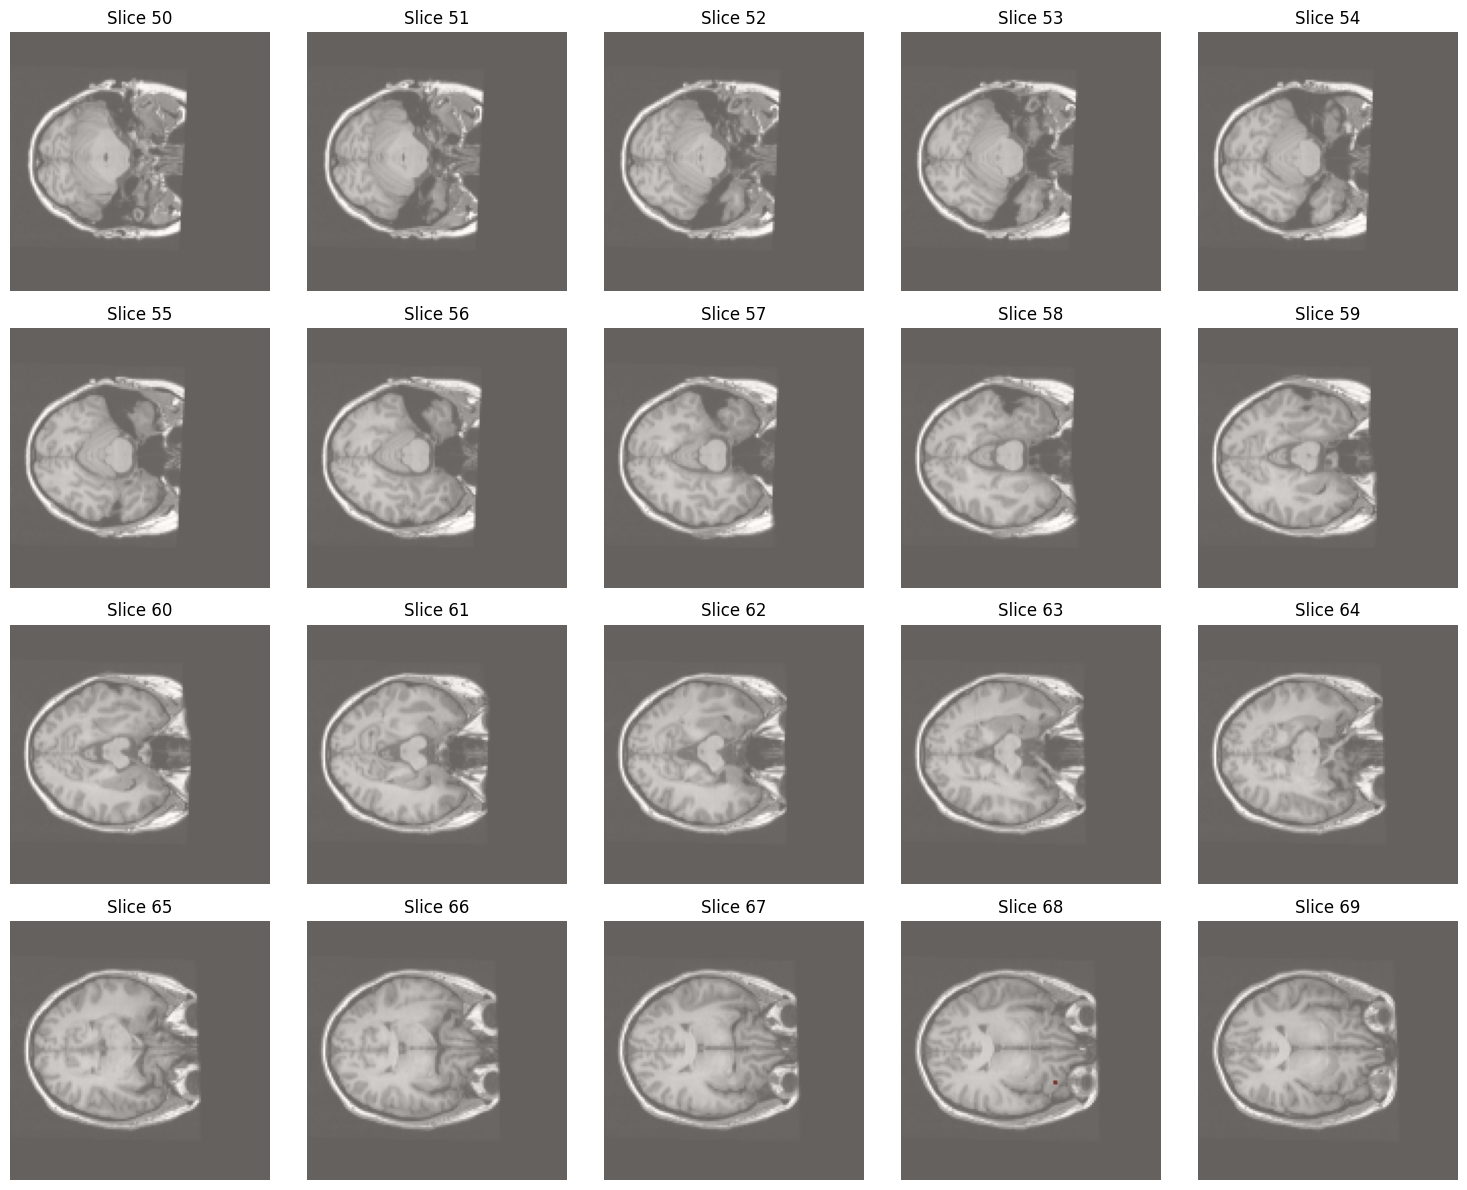

In [25]:
# Example: show one preprocessed scan with lesion
scan_id = list(all_preprocessed_data.keys())[0]
scan_tensor = all_preprocessed_data[scan_id]["scan"]
lesion_tensor = all_preprocessed_data[scan_id]["lesion"]

print(scan_tensor.shape)  # should be [1, D, H, W]


show_multiple_slices(scan_tensor, lesion_tensor, axis=2, start_idx=50)



### Visualize 3d lesions

In [26]:


def plot_3d_lesion(scan_tensor, lesion_tensor, threshold=0.5):
    scan_np = scan_tensor.squeeze().cpu().numpy()
    lesion_np = lesion_tensor.squeeze().cpu().numpy()

    # Create an isosurface for the lesion mask
    fig = go.Figure()

    # Lesion isosurface
    # fig.add_trace(go.Isosurface(
    #     x=np.arange(lesion_np.shape[0]),
    #     y=np.arange(lesion_np.shape[1]),
    #     z=np.arange(lesion_np.shape[2]),
    #     value=lesion_np,
    #     isomin=0.01,
    #     isomax=1,
    #     surface_count=1,
    #     colorscale='Reds',
    #     opacity=0.9,
    #     caps=dict(x_show=False, y_show=False, z_show=False),
    #     name='Lesion'
    # ))

    # Optionally, add scan volume (e.g. low opacity)
    fig.add_trace(go.Volume(
        x=np.arange(lesion_np.shape[0]),
        y=np.arange(lesion_np.shape[1]),
        z=np.arange(lesion_np.shape[2]),
        value=lesion_np,
        opacity=0.5,        # Adjust for visibility
        surface_count=15,   # Number of isosurfaces inside the volume
        colorscale='Reds',
        name='Lesion Volume'
    ))

    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="3D Lesion Visualization"
    )
    fig.show()


In [27]:
# scan_id = list(all_preprocessed_data.keys())[0]
# scan_tensor = all_preprocessed_data[scan_id]["scan"]
# lesion_tensor = all_preprocessed_data[scan_id]["lesion"]

# # Convert tensors to numpy for inspection
# scan_np = scan_tensor.squeeze().cpu().numpy()
# lesion_np = lesion_tensor.squeeze().cpu().numpy()

# print("Scan shape:", scan_np.shape, "Min:", scan_np.min(), "Max:", scan_np.max())
# print("Lesion shape:", lesion_np.shape, "Min:", lesion_np.min(), "Max:", lesion_np.max())

# print("Lesion voxel count:", (lesion_np > 0.1).sum())

# plot_3d_lesion(scan_tensor, lesion_tensor)


## Training the model

### Defining the class for creating Pytorch Dataset

In [28]:
class TBI3DSegmentationDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.ids = list(data_dict.keys())
        self.data = data_dict
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        scan_id = self.ids[idx]
        scan = self.data[scan_id]["scan"]
        lesion = self.data[scan_id]["lesion"]

        # Ensure shape is (C, D, H, W)
        scan = scan.squeeze()  # remove extra dims if any
        lesion = lesion.squeeze()

        scan = scan.unsqueeze(0)
        lesion = lesion.unsqueeze(0)

        if self.transform:
            scan, lesion = self.transform(scan, lesion)

        return scan, lesion



### Split Train/Val + Create Loaders

### 3DUNET Class

In [29]:
class DoubleConv3D(nn.Module):
    """(Conv3D => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()

        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Down path
        for feature in features:
            self.encoder.append(DoubleConv3D(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv3D(features[-1], features[-1]*2)

        # Up path
        self.up_transpose = nn.ModuleList()
        self.decoder = nn.ModuleList()
        reversed_features = features[::-1]

        for feature in reversed_features:
            self.up_transpose.append(
                nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(
                DoubleConv3D(feature*2, feature)
            )

        # Final layer
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Downsampling
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Upsampling
        for i in range(len(self.up_transpose)):
            x = self.up_transpose[i](x)
            skip = skip_connections[i]

            if x.shape != skip.shape:
                # Ensure spatial alignment
                x = F.interpolate(x, size=skip.shape[2:])

            x = torch.cat((skip, x), dim=1)
            x = self.decoder[i](x)

        return self.final_conv(x)  # logits, use with BCEWithLogitsLoss or sigmoid

Improved 3DUnet Architecture

In [30]:
class AttentionGate3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ImprovedUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256, 512]):
        super().__init__()
        
        # Encoder
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        for feature in features:
            self.encoder.append(DoubleConv3D(in_channels, feature))
            in_channels = feature
        
        # Bottleneck with dropout
        self.bottleneck = nn.Sequential(
            DoubleConv3D(features[-1], features[-1]*2),
            nn.Dropout3d(0.5)
        )
        
        # Decoder with attention gates
        self.up_transpose = nn.ModuleList()
        self.attention_gates = nn.ModuleList()
        self.decoder = nn.ModuleList()
        
        reversed_features = features[::-1]
        for i, feature in enumerate(reversed_features):
            self.up_transpose.append(
                nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.attention_gates.append(
                AttentionGate3D(feature, feature, feature//2)
            )
            self.decoder.append(DoubleConv3D(feature*2, feature))
        
        # Final layers with deep supervision
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
        
        # Deep supervision outputs
        self.deep_outputs = nn.ModuleList([
            nn.Conv3d(feat, out_channels, kernel_size=1) 
            for feat in reversed_features[:-1]
        ])

    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        deep_outputs = []
        
        # Decoder with attention
        for i in range(len(self.up_transpose)):
            x = self.up_transpose[i](x)
            skip = skip_connections[i]
            
            # Attention gate
            skip = self.attention_gates[i](x, skip)
            
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            
            x = torch.cat((skip, x), dim=1)
            x = self.decoder[i](x)
            
            # Deep supervision
            if i < len(self.deep_outputs):
                deep_out = self.deep_outputs[i](x)
                deep_outputs.append(deep_out)
        
        main_output = self.final_conv(x)
        
        if self.training:
            return main_output, deep_outputs
        else:
            return main_output

### Initialize Model, Loss, Optimizer, Metrics

In [31]:
class SoftDiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        union = preds.sum() + targets.sum()
        dice = (2. * intersection + self.eps) / (union + self.eps)
        return 1 - dice


Advanced Loss Function

In [32]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=2.0, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        
        # Flatten for calculation
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # True Positives, False Positives & False Negatives
        tp = (inputs * targets).sum()
        fp = ((1 - targets) * inputs).sum()
        fn = (targets * (1 - inputs)).sum()
        
        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        focal_tversky = torch.pow((1 - tversky), self.gamma)
        
        return focal_tversky

class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(75.0))
        self.dice = SoftDiceLoss()
        self.focal_tversky = FocalTverskyLoss()
    
    def forward(self, outputs, targets, deep_outputs=None):
        main_loss = (0.3 * self.bce(outputs, targets) + 
                    0.4 * self.dice(outputs, targets) + 
                    0.3 * self.focal_tversky(outputs, targets))
        
        # Deep supervision loss
        if deep_outputs is not None:
            deep_loss = 0
            for deep_out in deep_outputs:
                # Resize deep output to match target
                deep_resized = F.interpolate(deep_out, size=targets.shape[2:], mode='trilinear')
                deep_loss += self.dice(deep_resized, targets)
            main_loss += 0.2 * deep_loss / len(deep_outputs)
        
        return main_loss

In [33]:
# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

def train_epoch_improved(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    total_dice = 0.0
    
    for scans, masks in tqdm(train_loader, desc="Training"):
        scans, masks = scans.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            if hasattr(model, 'training') and model.training:
                outputs, deep_outputs = model(scans)
                loss = criterion(outputs, masks, deep_outputs)
            else:
                outputs = model(scans)
                loss = criterion(outputs, masks)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        total_dice += dice_coefficient(outputs, masks)
    
    return total_loss / len(train_loader), total_dice / len(train_loader)

/tmp/ipykernel_35/235264435.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [34]:
def dice_coefficient(preds, targets, threshold=0.3, eps=1e-6):
    with torch.no_grad():
        preds = torch.sigmoid(preds)
        preds = (preds > threshold).float()

        intersection = (preds * targets).sum(dim=(1, 2, 3, 4))
        union = preds.sum(dim=(1, 2, 3, 4)) + targets.sum(dim=(1, 2, 3, 4))

        dice = (2. * intersection + eps) / (union + eps)
        return dice.mean().item()


### Optuna Hyperparameter Optimization Function

In [35]:
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [1, 2, 4])

    # Create train/val split INSIDE the function
    full_dataset = TBI3DSegmentationDataset(all_preprocessed_data)
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

    # Data loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    # Model and optimizer
    model = ImprovedUNet3D(in_channels=1, out_channels=1).to(device)
    criterion = CombinedLoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = torch.cuda.amp.GradScaler()

    # Train for 1 epoch (or more for better results)
    train_epoch_improved(model, train_loader, criterion, optimizer, scaler, device)

    # Validation
    model.eval()
    val_dice = 0.0
    with torch.no_grad():
        for scans, masks in val_loader:
            scans, masks = scans.to(device), masks.to(device)
            result = model(scans)
            if isinstance(result, tuple):
                outputs, _ = result
            else:
                outputs = result
            val_dice += dice_coefficient(outputs, masks)
    avg_val_dice = val_dice / len(val_loader)
    return avg_val_dice  # Optuna will maximize this

In [37]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)  # You can increase n_trials for a more thorough search

print("Best hyperparameters:", study.best_params)
print("Best Dice score:", study.best_value)

[I 2025-06-29 10:06:41,169] A new study created in memory with name: no-name-9f6be594-1b83-4258-a69f-d7c78a035edf
/tmp/ipykernel_35/1300572942.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Training:   0%|          | 0/248 [00:00<?, ?it/s]/tmp/ipykernel_35/235264435.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 248/248 [06:03<00:00,  1.47s/it]
[I 2025-06-29 10:12:57,778] Trial 0 finished with value: 0.007738793147937721 and parameters: {'lr': 0.0002760454874933841, 'weight_decay': 0.00041546939792812005, 'batch_size': 2}. Best is trial 0 with value: 0.007738793147937721.
Training: 100%|██████████| 248/248 [06:03<00:00,  1.47s/it]
[I 2025-06-29 10:19:14,456] Trial 1 finished with value: 0.011986128673809502 and parameter

Best hyperparameters: {'lr': 0.0006471944617040697, 'weight_decay': 2.077913349412578e-06, 'batch_size': 2}
Best Dice score: 0.011986128673809502


In [38]:
best_lr = study.best_params['lr']
best_weight_decay = study.best_params['weight_decay']
best_batch_size = study.best_params['batch_size']

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "all_masks_lesion_fix_optuna_unet3d_model.pt"

# Create proper train/val split
full_dataset = TBI3DSegmentationDataset(all_preprocessed_data)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# Data loaders
# Data loaders with best batch size
train_loader = DataLoader(train_ds, batch_size=best_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=best_batch_size, shuffle=False, num_workers=2)

# Model and optimizer with best hyperparameters
model = ImprovedUNet3D(in_channels=1, out_channels=1).to(device)
criterion = CombinedLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
# Remove conflicting schedulers and use only this:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',          # Monitor for maximum (Dice score)
    factor=0.5,          # Reduce LR by half
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-7,         # Minimum learning rate
    verbose=True
)

# Training variables
best_dice = 0.0
trigger_times = 0
patience = 10
num_epochs = 30

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training + Validation Loop

In [39]:
train_loss_list = []
val_loss_list = []
train_dice_list = []
val_dice_list = []

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

print(f"Starting training with {len(train_loader)} training batches and {len(val_loader)} validation batches")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0.0
    total_dice = 0.0

    for scans, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        scans, masks = scans.to(device), masks.to(device)

        optimizer.zero_grad()
        
        # Use mixed precision training
        with torch.cuda.amp.autocast():
            # Handle both basic and improved UNet
            if isinstance(model, ImprovedUNet3D):
                outputs, deep_outputs = model(scans)
                loss = criterion(outputs, masks, deep_outputs)
            else:
                outputs = model(scans)
                loss = criterion(outputs, masks)

        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_dice += dice_coefficient(outputs, masks)

    # Calculate averages - FIX: Complete the calculation
    avg_train_loss = total_loss / len(train_loader)
    avg_train_dice = total_dice / len(train_loader)
    train_loss_list.append(avg_train_loss)
    train_dice_list.append(avg_train_dice)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_dice = 0.0

    with torch.no_grad():
        for scans, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            scans, masks = scans.to(device), masks.to(device)

            # FIX: Handle dual output in validation too
            result = model(scans)
            if isinstance(result, tuple):
                outputs, deep_outputs = result
                loss = criterion(outputs, masks, deep_outputs)
            else:
                outputs = result
                loss = criterion(outputs, masks)


            val_loss += loss.item()
            val_dice += dice_coefficient(outputs, masks)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    val_loss_list.append(avg_val_loss)
    val_dice_list.append(avg_val_dice)

    # Scheduler step
    scheduler.step(avg_val_dice)

    # Logging
    print(f"\n📊 Epoch {epoch+1}/{num_epochs} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f} | Dice: {avg_train_dice:.4f}")
    print(f"Val   Loss: {avg_val_loss:.4f} | Dice: {avg_val_dice:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Save best model
    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        torch.save(model.state_dict(), model_path)
        print(f"✅ Saved best model at epoch {epoch+1} with Dice: {best_dice:.4f}")
        trigger_times = 0

        # Save training stats
        stats_path = model_path.replace('.pt', '.txt')
        with open(stats_path, 'w') as f:
            f.write(f"Best Epoch: {epoch+1}\n")
            f.write(f"Best Val Dice: {best_dice:.4f}\n\n")
            f.write("Epoch\tTrain Loss\tVal Loss\tTrain Dice\tVal Dice\n")
            for i in range(epoch + 1):
                f.write(f"{i+1}\t{train_loss_list[i]:.4f}\t{val_loss_list[i]:.4f}\t"
                        f"{train_dice_list[i]:.4f}\t{val_dice_list[i]:.4f}\n")

    else:
        trigger_times += 1
        print(f"⚠️ No improvement. Patience counter: {trigger_times}/{patience}")

        if trigger_times >= patience:
            print("🛑 Early stopping triggered.")
            break

print(f"\n🎉 Training completed! Best Dice score: {best_dice:.4f}")

/tmp/ipykernel_35/2083282507.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting training with 248 training batches and 28 validation batches


Epoch 1/30 [Train]:   0%|          | 0/248 [00:00<?, ?it/s]/tmp/ipykernel_35/2083282507.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 1/30 Summary:
Train Loss: 0.9758 | Dice: 0.0481
Val   Loss: 0.7312 | Dice: 0.0172
Learning Rate: 6.47e-04
✅ Saved best model at epoch 1 with Dice: 0.0172


Epoch 2/30 [Val]: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s]



📊 Epoch 2/30 Summary:
Train Loss: 0.9296 | Dice: 0.0192
Val   Loss: 0.7169 | Dice: 0.0270
Learning Rate: 6.47e-04
✅ Saved best model at epoch 2 with Dice: 0.0270


Epoch 3/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 3/30 Summary:
Train Loss: 0.9161 | Dice: 0.0692
Val   Loss: 0.7147 | Dice: 0.0079
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 1/10


Epoch 4/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 4/30 Summary:
Train Loss: 0.9076 | Dice: 0.0317
Val   Loss: 0.6986 | Dice: 0.0158
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 2/10


Epoch 5/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 5/30 Summary:
Train Loss: 0.9056 | Dice: 0.0296
Val   Loss: 0.7186 | Dice: 0.0065
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 3/10


Epoch 6/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 6/30 Summary:
Train Loss: 0.9100 | Dice: 0.0279
Val   Loss: 0.7012 | Dice: 0.0134
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 4/10


Epoch 7/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 7/30 Summary:
Train Loss: 0.8968 | Dice: 0.0448
Val   Loss: 0.6950 | Dice: 0.0438
Learning Rate: 6.47e-04
✅ Saved best model at epoch 7 with Dice: 0.0438


Epoch 8/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 8/30 Summary:
Train Loss: 0.8945 | Dice: 0.0414
Val   Loss: 0.7016 | Dice: 0.0142
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 1/10


Epoch 9/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]



📊 Epoch 9/30 Summary:
Train Loss: 0.8901 | Dice: 0.0758
Val   Loss: 0.6926 | Dice: 0.0304
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 2/10


Epoch 10/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 10/30 Summary:
Train Loss: 0.8919 | Dice: 0.0518
Val   Loss: 0.6889 | Dice: 0.0279
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 3/10


Epoch 11/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 11/30 Summary:
Train Loss: 0.8915 | Dice: 0.0572
Val   Loss: 0.6859 | Dice: 0.1035
Learning Rate: 6.47e-04
✅ Saved best model at epoch 11 with Dice: 0.1035


Epoch 12/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 12/30 Summary:
Train Loss: 0.8873 | Dice: 0.0688
Val   Loss: 0.6867 | Dice: 0.0281
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 1/10


Epoch 13/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 13/30 Summary:
Train Loss: 0.8784 | Dice: 0.0633
Val   Loss: 0.6963 | Dice: 0.2986
Learning Rate: 6.47e-04
✅ Saved best model at epoch 13 with Dice: 0.2986


Epoch 14/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 14/30 Summary:
Train Loss: 0.8882 | Dice: 0.1325
Val   Loss: 0.6790 | Dice: 0.0593
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 1/10


Epoch 15/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.36it/s]



📊 Epoch 15/30 Summary:
Train Loss: 0.8727 | Dice: 0.0842
Val   Loss: 0.6801 | Dice: 0.2819
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 2/10


Epoch 16/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.36it/s]



📊 Epoch 16/30 Summary:
Train Loss: 0.8796 | Dice: 0.0851
Val   Loss: 0.6890 | Dice: 0.0250
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 3/10


Epoch 17/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.36it/s]



📊 Epoch 17/30 Summary:
Train Loss: 0.8658 | Dice: 0.0941
Val   Loss: 0.8281 | Dice: 0.0054
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 4/10


Epoch 18/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 18/30 Summary:
Train Loss: 0.9015 | Dice: 0.0537
Val   Loss: 0.7077 | Dice: 0.0158
Learning Rate: 6.47e-04
⚠️ No improvement. Patience counter: 5/10


Epoch 19/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 19/30 Summary:
Train Loss: 0.8863 | Dice: 0.0718
Val   Loss: 0.6811 | Dice: 0.0539
Learning Rate: 3.24e-04
⚠️ No improvement. Patience counter: 6/10


Epoch 20/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]



📊 Epoch 20/30 Summary:
Train Loss: 0.8573 | Dice: 0.1166
Val   Loss: 0.6807 | Dice: 0.1971
Learning Rate: 3.24e-04
⚠️ No improvement. Patience counter: 7/10


Epoch 21/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]



📊 Epoch 21/30 Summary:
Train Loss: 0.8414 | Dice: 0.1338
Val   Loss: 0.6777 | Dice: 0.1254
Learning Rate: 3.24e-04
⚠️ No improvement. Patience counter: 8/10


Epoch 22/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]



📊 Epoch 22/30 Summary:
Train Loss: 0.8491 | Dice: 0.1058
Val   Loss: 0.6663 | Dice: 0.2779
Learning Rate: 3.24e-04
⚠️ No improvement. Patience counter: 9/10


Epoch 23/30 [Val]: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]


📊 Epoch 23/30 Summary:
Train Loss: 0.8385 | Dice: 0.1316
Val   Loss: 0.6686 | Dice: 0.0554
Learning Rate: 3.24e-04
⚠️ No improvement. Patience counter: 10/10
🛑 Early stopping triggered.

🎉 Training completed! Best Dice score: 0.2986


### Import the model from drive

In [40]:
# model = UNet3D(in_channels=1, out_channels=1)
# model.load_state_dict(torch.load(model_path))
# model.to(device)
# model.eval()

### Perform inference on validation data

In [41]:
# --- Evaluation: Print segmentation stats on validation set ---

def eval_segmentation_stats(model, val_loader, device, threshold=0.3):
    model.eval()
    TP = FP = FN = TN = 0
    dice_scores = []
    vol_diffs = []
    with torch.no_grad():
        for scans, masks in tqdm(val_loader, desc="Validation Stats"):
            scans = scans.to(device)
            masks = masks.to(device)
            result = model(scans)
            if isinstance(result, tuple):
                outputs, _ = result
            else:
                outputs = result
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            # Flatten for stats
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)

            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()

            # Dice
            intersection = (preds_flat * masks_flat).sum().item()
            union = preds_flat.sum().item() + masks_flat.sum().item()
            dice = (2 * intersection) / (union + 1e-6) if union > 0 else 1.0
            dice_scores.append(dice)

            # Volumetric difference (absolute voxel count difference)
            vol_pred = preds_flat.sum().item()
            vol_true = masks_flat.sum().item()
            vol_diff = abs(vol_pred - vol_true)
            vol_diffs.append(vol_diff)

    print("\n--- Validation Segmentation Stats ---")
    print(f"True Positives:  {TP}")
    print(f"False Positives: {FP}")
    print(f"False Negatives: {FN}")
    print(f"True Negatives:  {TN}")
    print(f"Mean Dice:       {np.mean(dice_scores):.4f}")
    print(f"Mean Vol Diff:   {np.mean(vol_diffs):.2f} voxels")
    print(f"Total Vol Pred:  {TP+FP}")
    print(f"Total Vol True:  {TP+FN}")

# Usage: run after training
eval_segmentation_stats(model, val_loader, device)

Validation Stats: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]


--- Validation Segmentation Stats ---
True Positives:  10996
False Positives: 208129
False Negatives: 17027
True Negatives:  117204360
Mean Dice:       0.0633
Mean Vol Diff:   6825.07 voxels
Total Vol Pred:  219125
Total Vol True:  28023


### Download Saved Processed Data

In [42]:
# !zip -r PreprocessedData.zip /kaggle/working/PreprocessedData


In [43]:
# from IPython.display import FileLink
# FileLink("PreprocessedData.zip")
